# Разработка решения для интернет-магазина «В один клик», увеличивающего покупательскую активность клиентов.

В отдел цифровых технологий интернет-магазина «В один клик» поступило поручение с поиском решений, которые позволят персонализировать предложения постоянным клиентам маназина, тем самым увеличив их покупательскую активность.

Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться и т.к. привлекать новых клиентов уже не так эффективно (о магазине и так знает большая часть целевой аудитории) было решено удерживать активность постоянных клиентов. И этого можно добиться как раз таки с помощью персонализированных предложений, которые будут основаны на бизнес-моделировании и анализе данных интернет-магазина.

Для достижения поставленных задач, нам необходимо реализовать следующие решения, одобренные руководством интернет-магазина:
Для начала, нам нужно промаркировать уровень финансовой активности постоянных покупателей («снизилась» или «прежний уровень») и после собрать данные по клиентам по следующим группам:

- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

Далее, нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. Потом, в исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца. И наконец, используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения. Все эти действия помогут увеличить покупательскую активность клиетов интернет-магазина.

## Шаг 1. Загрузка данных

In [1]:
!pip install numba==0.59.1 -q
!pip install numpy==1.26.4 -q
!pip install scipy==1.13.1 -q
!pip install -U scikit-learn -q
!pip install seaborn==0.13.2 -q
!pip install matplotlib==3.9.0 -q
!pip install shap -q
!pip install phik==0.12.4 -q
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import phik
import warnings
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            mean_absolute_error, mean_squared_error,
                            precision_score,
                            recall_score,
                            r2_score, f1_score, make_scorer, roc_auc_score, auc, roc_curve)

from sklearn.model_selection import train_test_split
import pylab 
from scipy import stats
from phik import phik_matrix
import scipy.stats as stats
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
market_file = pd.read_csv('market_file.csv')
market_money = pd.read_csv('market_money.csv')
market_time = pd.read_csv('market_time.csv')
money = pd.read_csv('money.csv', sep=';', decimal = ',')

In [3]:
display(market_file.head(10))
market_file.info()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   
5  215353                 Снизилась   стандартт                 да   
6  215354                 Снизилась   стандартт                 да   
7  215355                 Снизилась   стандартт                нет   
8  215356                 Снизилась   стандартт                 да   
9  215357                 Снизилась   стандартт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   
6                 5.1                     3           431               0.23   
7                 4.7                     4           284               0.17   
8                 4.2                     4           192               0.14   
9                 3.9                     5           154               0.00   

             Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                Товары для детей                                    6   
1                Товары для детей                                    4   
2               Домашний текстиль                                    5   
3                Товары для детей                                    5   
4                Товары для детей                                    3   
5               Домашний текстиль                                    4   
6           Косметика и аксесуары                                    2   
7                Товары для детей                                    5   
8           Косметика и аксесуары                                    2   
9  Техника для красоты и здоровья                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4  
6                                   3               7                 2  
7                                   1               6                 4  
8                                   2               1                 3  
9                                   3               9                 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [4]:
display(market_money.head(10))
market_money.info() 

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4
8  215350     предыдущий_месяц   5457.5
9  215351        текущий_месяц   6610.4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [5]:
display(market_time.head(10))
market_time.info() 

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
5  215350  предыдцщий_месяц      8
6  215351     текущий_месяц     13
7  215351  предыдцщий_месяц     11
8  215352     текущий_месяц     11
9  215352  предыдцщий_месяц      8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [6]:
display(money.head(10))
money.info() 

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
5  215353     3.95
6  215354     3.62
7  215355     5.26
8  215356     4.93
9  215357     4.66

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Как мы сразу можем заметить в исходных датафреймах отсутсвуют пропуски и во всех столбцах используется корректный тип данных.

## Шаг 2. Предобработка данных

Далее займемся предобработкой исходных данных.
Для начала изменим названия столбцов приведя их к нижнему регистру, применив метод str.lower

In [7]:
market_file.columns = market_file.columns.str.lower()
market_money.columns = market_money.columns.str.lower()
market_time.columns = market_time.columns.str.lower()
money.columns = money.columns.str.lower()
print(market_file.columns)
print(market_money.columns)
print(market_time.columns)
print(money.columns)

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


Заменим пропуски в названиях столбцов у датафрейма market_file

In [8]:
market_file.columns = market_file.columns.str.replace(' ', '_')
print(market_file.columns)  # Проверим наше преобразование
display(market_file.head(3))

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')


id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5

Перепроверим наши датасеты на наличие пропусков

In [9]:
print(market_file.isna().sum())
print(market_money.isna().sum())
print(market_time.isna().sum())
print(money.isna().sum())

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64
id         0
период     0
выручка    0
dtype: int64
id        0
период    0
минут     0
dtype: int64
id         0
прибыль    0
dtype: int64


Как видно выше, пропуски в наших датасетах отсутсвуют. Произведем проверку наших датасетов на наличие полных дубликатов.

In [10]:
print(market_file.duplicated().sum())
print(market_money.duplicated().sum())
print(market_time.duplicated().sum())
print(money.duplicated().sum())

0
0
0
0


Полных дубликатов так же не выявлено. Проверим на неявные дубликаты

In [11]:
print(market_file['покупательская_активность'].unique())
print(market_file['покупательская_активность'].value_counts())
print()
print(market_file['тип_сервиса'].unique())
print(market_file['тип_сервиса'].value_counts())
print()
print(market_file['разрешить_сообщать'].unique())
print(market_file['разрешить_сообщать'].value_counts())
print()
print(market_file['популярная_категория'].unique())
print(market_file['популярная_категория'].value_counts())
print()
print(market_money['период'].unique())
print(market_money['период'].value_counts())
print()
print(market_time['период'].unique())
print(market_time['период'].value_counts())#смотрим все значения в категориальных столбцах

['Снизилась' 'Прежний уровень']
покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

['премиум' 'стандартт' 'стандарт']
тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

['да' 'нет']
разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

['текущий_месяц' 

После изучения исходных данных датафреймов изменим наименования в категориях 'тип_сервиса' датафрема market_file и 'период' в датафрейме market_time.

In [12]:
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
market_money.loc[market_money['период'] == 'препредыдущий_месяц', 'период'] = 'предпредыдущий_месяц'
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц' #исправляем опечатки

In [13]:
print(market_file['id'].value_counts())
print(market_money['id'].value_counts())
print(market_time['id'].value_counts())
print(money['id'].value_counts())

id
215348    1
216202    1
216220    1
216219    1
216218    1
         ..
215779    1
215778    1
215777    1
215776    1
216647    1
Name: count, Length: 1300, dtype: int64
id
215348    3
216202    3
216220    3
216219    3
216218    3
         ..
215779    3
215778    3
215777    3
215776    3
216647    3
Name: count, Length: 1300, dtype: int64
id
215348    2
216202    2
216220    2
216219    2
216218    2
         ..
215779    2
215778    2
215777    2
215776    2
216647    2
Name: count, Length: 1300, dtype: int64
id
215348    1
216202    1
216220    1
216219    1
216218    1
         ..
215779    1
215778    1
215777    1
215776    1
216647    1
Name: count, Length: 1300, dtype: int64


С данными все впорядке, т.к. в каждой таблице упоминается необходимое количество id

Во 2 шаге работы мы выполнили предобработку исходных данных, чтобы все дальнейшие наши действия были более точными и более полно отражали наше иссдедование. Сначала мы заменили наименования столбцов на нижний регистр и убрали пропуски между словами. После проверили наши датасеты на наличие пропусков. Их в данных не оказалось, поэтому после мы произвели проверку наших датасетов на наличие явных и неявных дубликатов. Явных дубликатов также не было, а неявные дубликаты мы заменили на верные наименования. Также проверили тип данных у исходных датафреймов и все типы были корректные, поэтому оставили их без изменений.

## Шаг 3. Исследовательский анализ данных

Далее, проведем исследовательский анализ данных из каждой таблицы и отберем клиентов с покупательской активностью не менее трёх месяцев. Для этого проанализируем датафрейм market_money и найдем таких покупателей.

In [14]:
display(market_money[market_money['выручка']==0.0])

id                период  выручка
0   215348  предпредыдущий_месяц      0.0
2   215348      предыдущий_месяц      0.0
28  215357  предпредыдущий_месяц      0.0
29  215357      предыдущий_месяц      0.0
34  215359      предыдущий_месяц      0.0
35  215359  предпредыдущий_месяц      0.0

Как мы видим, значения выручки равной 0.0 у 3-х пользователей с id 215348, 215357, 215359. Исключим этих клиентов, т.к. у них низкая покупательская активность.

In [15]:
print(market_file.shape)
print(market_money.shape)
print(market_time.shape)
print(money.shape)

(1300, 13)
(3900, 3)
(2600, 3)
(1300, 2)


In [16]:
market_file = market_file.loc[(market_file['id']!=215348) & (market_file['id']!=215357) & (market_file['id']!=215359)]
market_money = market_money.loc[(market_money['id']!=215348) & (market_money['id']!=215357) & (market_money['id']!=215359)]
market_time = market_time.loc[(market_time['id']!=215348) & (market_time['id']!=215357) & (market_time['id']!=215359)]
money = money.loc[(money['id']!=215348) & (money['id']!=215357) & (money['id']!=215359)]

In [17]:
print(market_file.shape)
print(market_money.shape)
print(market_time.shape)
print(money.shape) #проверка

(1297, 13)
(3891, 3)
(2594, 3)
(1297, 2)


Для начала, определим к каким признакам отнясятся все данные.

К количественным признакам:
- в датафрейме market_file относятся такие признаки, как 'маркет_актив6мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит'.
- в датафрейме market_money это 'выручка'.
- в датафрейме market_time это 'минут'.
- в датафрейме money это 'прибыль'.

К категориальным признакам относятся:
- в датафрейме market_file это 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория'.
- в датафрейме market_money это 'период'.
- в датафрейме market_time это 'период'.
- в датафрейме money категориальных признаков нет.

Проведем анализ количественных признаков для датасетов market_file, market_money, market_time и money

In [18]:
#датасет market_file
display(market_file[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']].describe())
print()
# транспонируем данные для большей наглядности 
display(market_file[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']].describe().T)

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count         1297.000000           1297.000000   1297.000000   
mean             4.254433              4.009252    602.993832   
std              1.015618              0.696048    249.101456   
min              0.900000              3.000000    121.000000   
25%              3.700000              4.000000    410.000000   
50%              4.200000              4.000000    607.000000   
75%              4.900000              4.000000    806.000000   
max              6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1297.000000                          1297.000000   
mean            0.320547                             3.267540   
std             0.249657                             1.354623   
min             0.110000                             1.000000   
25%             0.170000                             2.000000   
50%             0.240000                             3.000000   
75%             0.300000                             4.000000   
max             0.990000                             6.000000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1297.000000     1297.000000       1297.000000  
mean                             2.841172        4.184271          8.186584  
std                              1.973451        1.950973          3.977061  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

count        mean         std     min  \
маркет_актив_6_мес                   1297.0    4.254433    1.015618    0.90   
маркет_актив_тек_мес                 1297.0    4.009252    0.696048    3.00   
длительность                         1297.0  602.993832  249.101456  121.00   
акционные_покупки                    1297.0    0.320547    0.249657    0.11   
средний_просмотр_категорий_за_визит  1297.0    3.267540    1.354623    1.00   
неоплаченные_продукты_штук_квартал   1297.0    2.841172    1.973451    0.00   
ошибка_сервиса                       1297.0    4.184271    1.950973    0.00   
страниц_за_визит                     1297.0    8.186584    3.977061    1.00   

                                        25%     50%    75%      max  
маркет_актив_6_мес                     3.70    4.20    4.9     6.60  
маркет_актив_тек_мес                   4.00    4.00    4.0     5.00  
длительность                         410.00  607.00  806.0  1079.00  
акционные_покупки                      0.17    0.24    0.3     0.99  
средний_просмотр_категорий_за_визит    2.00    3.00    4.0     6.00  
неоплаченные_продукты_штук_квартал     1.00    3.00    4.0    10.00  
ошибка_сервиса                         3.00    4.00    6.0     9.00  
страниц_за_визит                       5.00    8.00   11.0    20.00

In [19]:
#датасеты market_money, market_time, money
display(market_money[['выручка']].describe().T)
display(market_time[['минут']].describe().T)
display(money[['прибыль']].describe().T)

count        mean          std     min     25%     50%     75%  \
выручка  3891.0  5033.71889  1768.471286  2758.7  4592.0  4959.0  5363.2   

              max  
выручка  106862.2

count       mean       std  min   25%   50%   75%   max
минут  2594.0  13.340401  4.081999  4.0  10.0  13.0  16.0  23.0

count     mean       std   min  25%   50%   75%   max
прибыль  1297.0  3.99761  1.010813  0.86  3.3  4.04  4.67  7.43

Построим графики по количественным признакам — гистограмму частотности распределения и ящик с усами для каждого признака

**1) 'Маркет актив 6 мес'.**

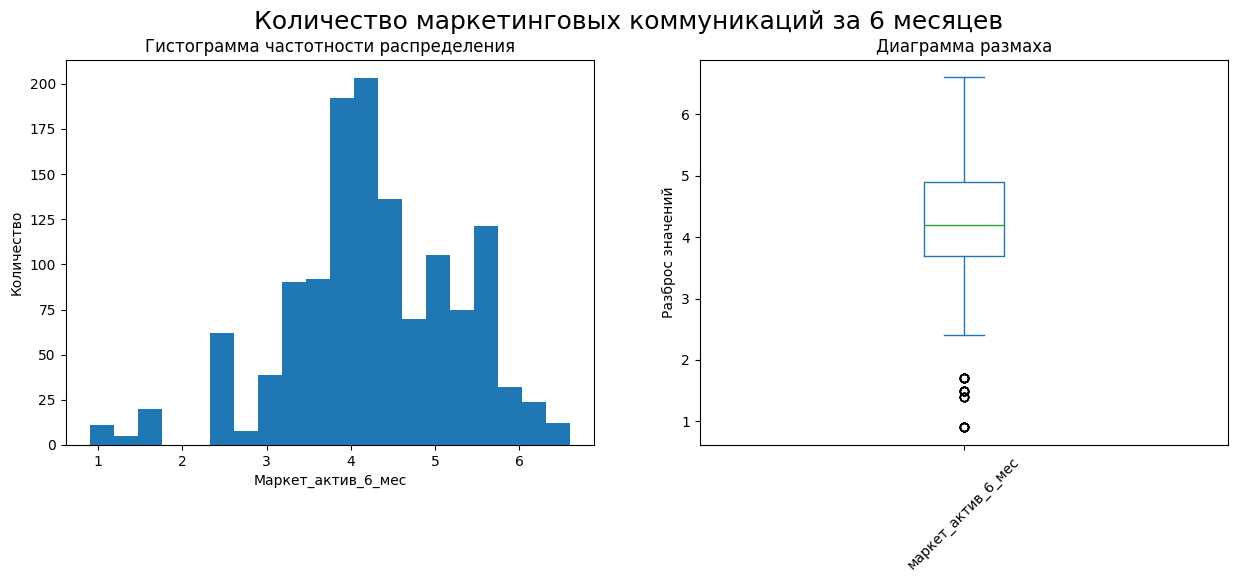

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Количество маркетинговых коммуникаций за 6 месяцев', fontsize=18)
market_file['маркет_актив_6_мес'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('Маркет_актив_6_мес')
axes[0].set_ylabel('Количество')

market_file['маркет_актив_6_мес'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Данные графики описывают среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. То есть, значения показывают, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента. Как мы можем заметить, большинство значений находится на промежуток от 3.7 до 4.9. Гистограмма похожа на график нормального распределения со смещением вправо.

**2) 'Маркет актив тек мес'.**

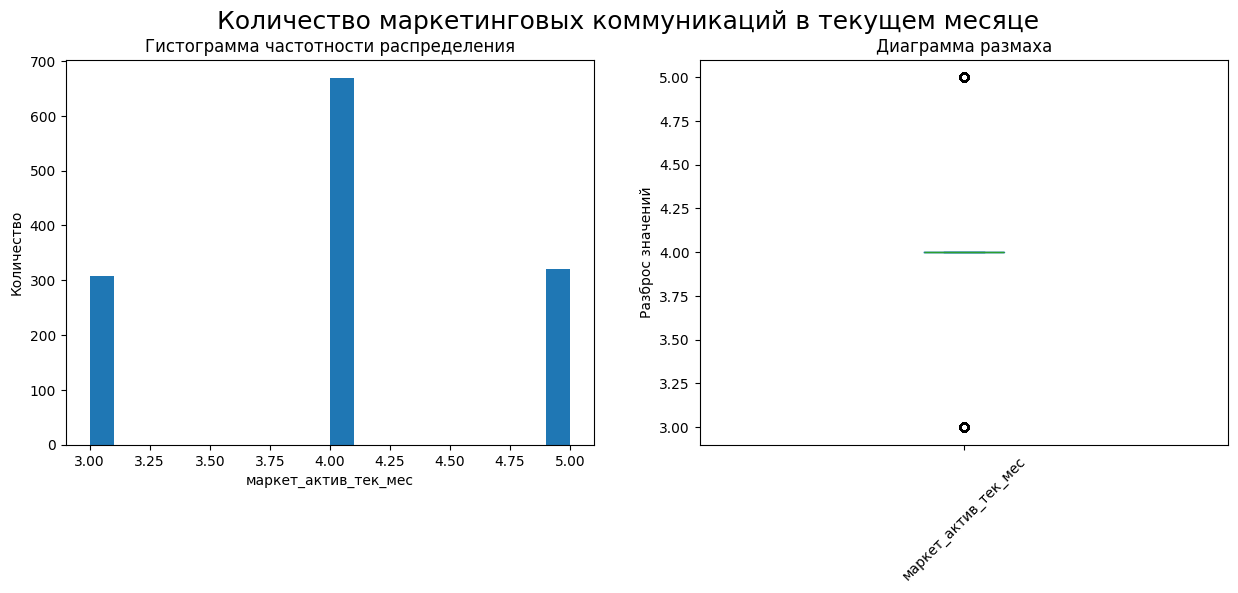

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Количество маркетинговых коммуникаций в текущем месяце', fontsize=18)
market_file['маркет_актив_тек_мес'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('маркет_актив_тек_мес')
axes[0].set_ylabel('Количество')

market_file['маркет_актив_тек_мес'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Данные графики показывают нам количество маркетинговых коммуникаций в текущем месяце. Диаграммы для параметра 'маркет_актив_тек_мес' выглядит так, потому что у нас всего 3 уникальных значения (3, 4, 5). Чаще всего у польщователей и компании 4 коммуникации.

**3) 'Длительность'.**

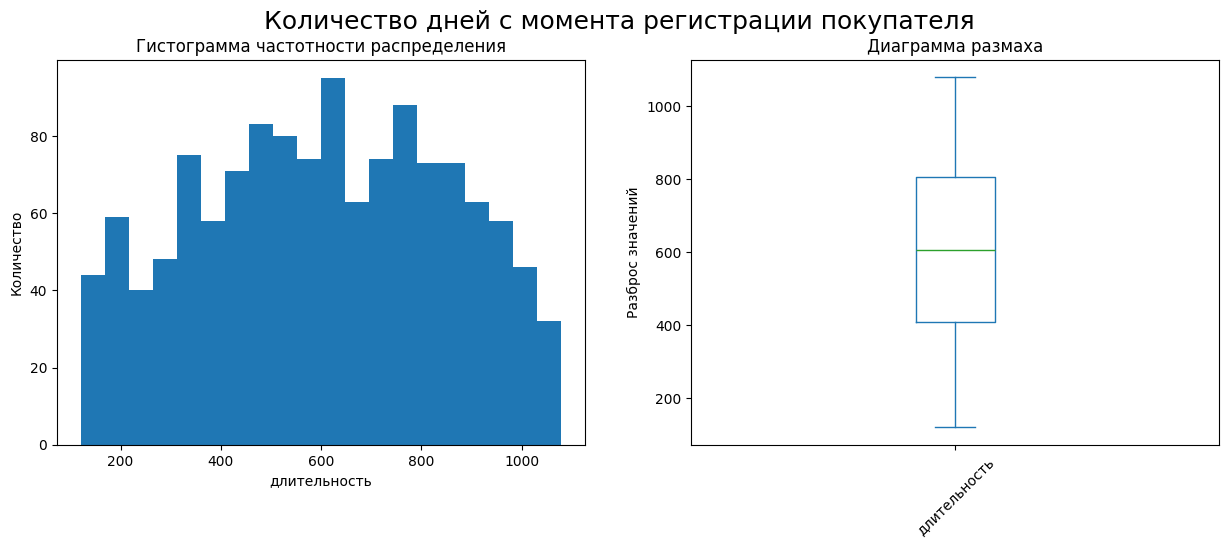

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Количество дней с момента регистрации покупателя', fontsize=18)
market_file['длительность'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('длительность')
axes[0].set_ylabel('Количество')

market_file['длительность'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Данные графики показывают нам количество дней с момента регистрации покупателя на сайте. Как мы можем заметить, большинство значениц находятся на промежутке от 410 дней до 806 дней. Гистограмма похожа на график нормального распределения. По диаграмме размаха выбрасов нет.

**4) 'Акционные покупки'.**

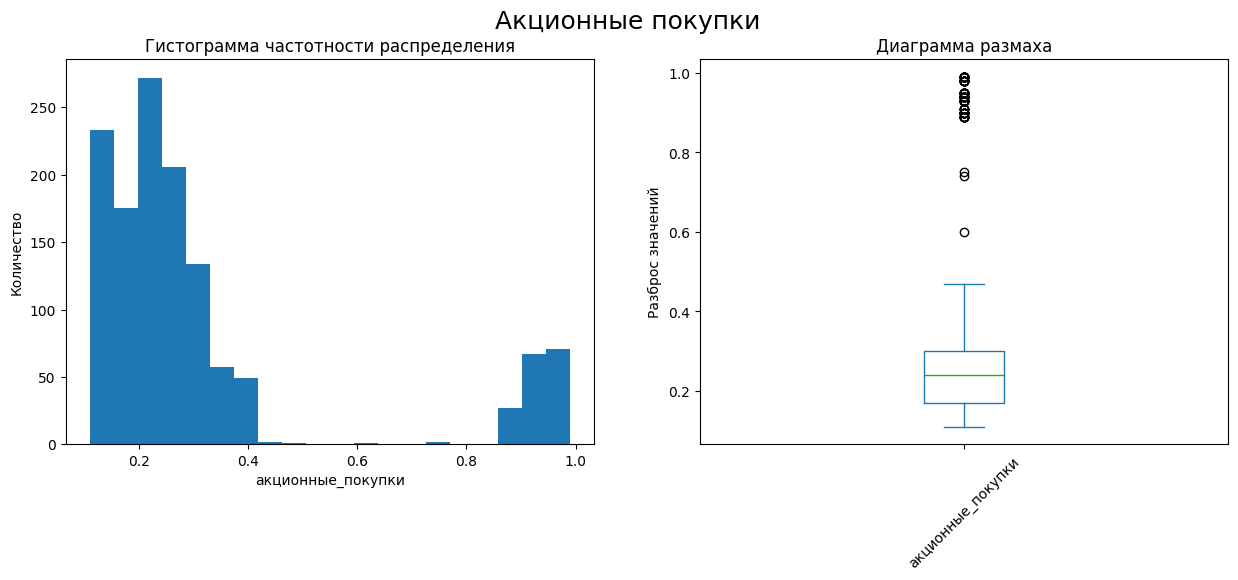

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Акционные покупки', fontsize=18)
market_file['акционные_покупки'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('акционные_покупки')
axes[0].set_ylabel('Количество')

market_file['акционные_покупки'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Данные графики показывают нам среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев. По гистограмме и диаграмме рахмаха мы видим, что в данных присутствуют выбросы. Большая часть значений находиться в промежутке от 0.17 до 0.3. Не будем удалять выбросы, т.к. тогда удалится значительное количество данных.

**5) 'Средний просмотр категорий за визит'**

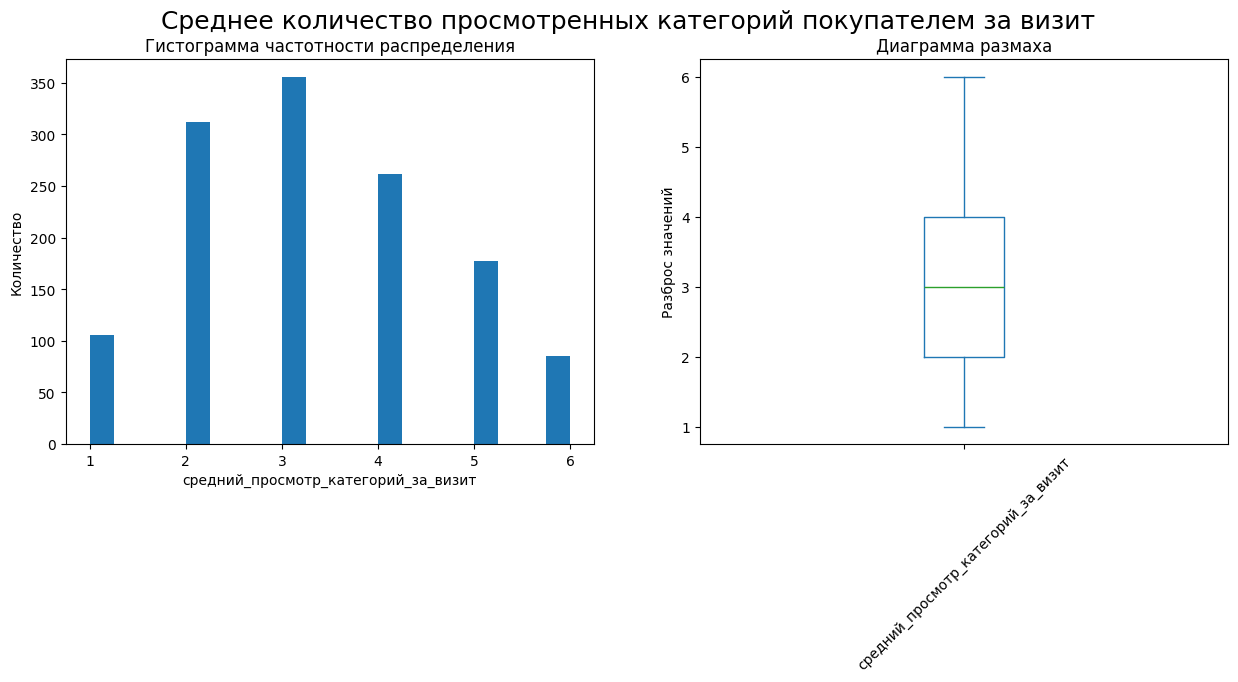

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Среднее количество просмотренных категорий покупателем за визит', fontsize=18)
market_file['средний_просмотр_категорий_за_визит'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('средний_просмотр_категорий_за_визит')
axes[0].set_ylabel('Количество')

market_file['средний_просмотр_категорий_за_визит'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Графики показывают нам, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца. В данных выбросов нет. Количество категорий варьируется от 1 до 6. В течение последнего месяца чаще всего в среднем покупатель просмотривает за визит 3 категории.

**6) 'Неоплаченные продукты штук квартал'**

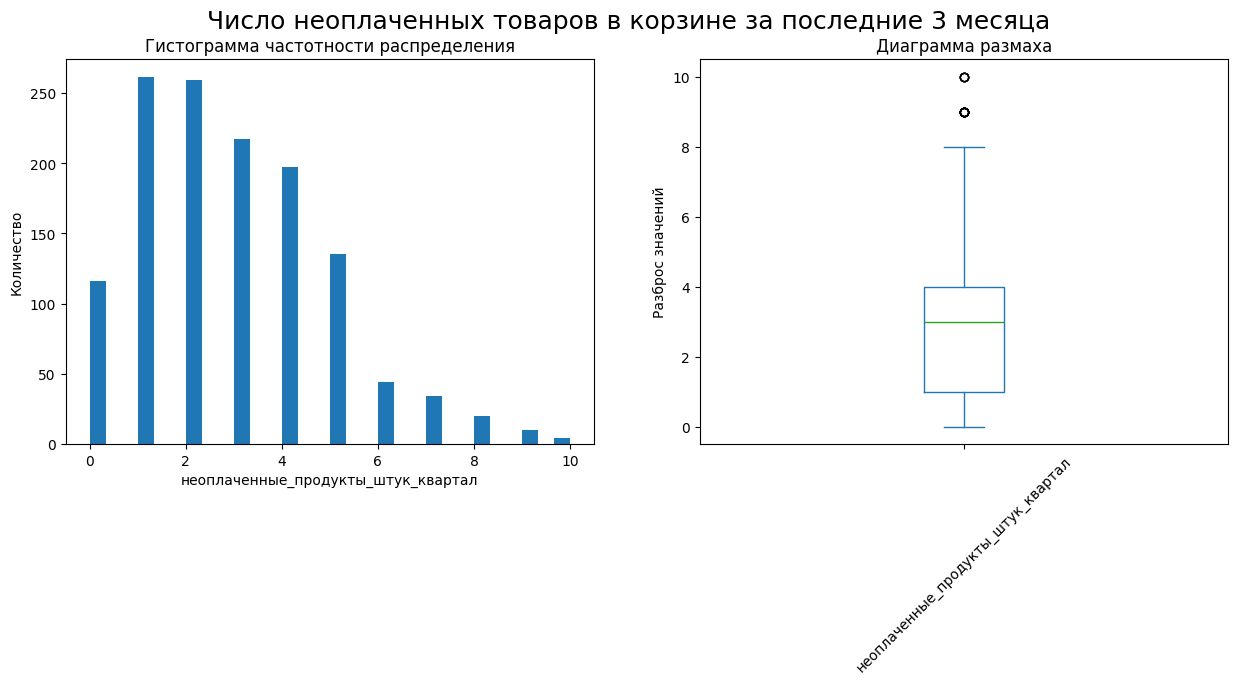

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Число неоплаченных товаров в корзине за последние 3 месяца', fontsize=18)
market_file['неоплаченные_продукты_штук_квартал'].plot(kind='hist', bins=30, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('неоплаченные_продукты_штук_квартал')
axes[0].set_ylabel('Количество')

market_file['неоплаченные_продукты_штук_квартал'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Все данные варьируются от 0 до 10. Большая часть значений находится на промежутке от 1 до 4. По диаграмме размаха мы можем сказать, что в данных присутствует незначительное количество выбрасов на значениях 9 и 10. Это означает, что есть небольшое количество пользователей, которые оставляют в своей корзине более 8 неоплаченных товаров

**7) 'Ошибка сервиса'**

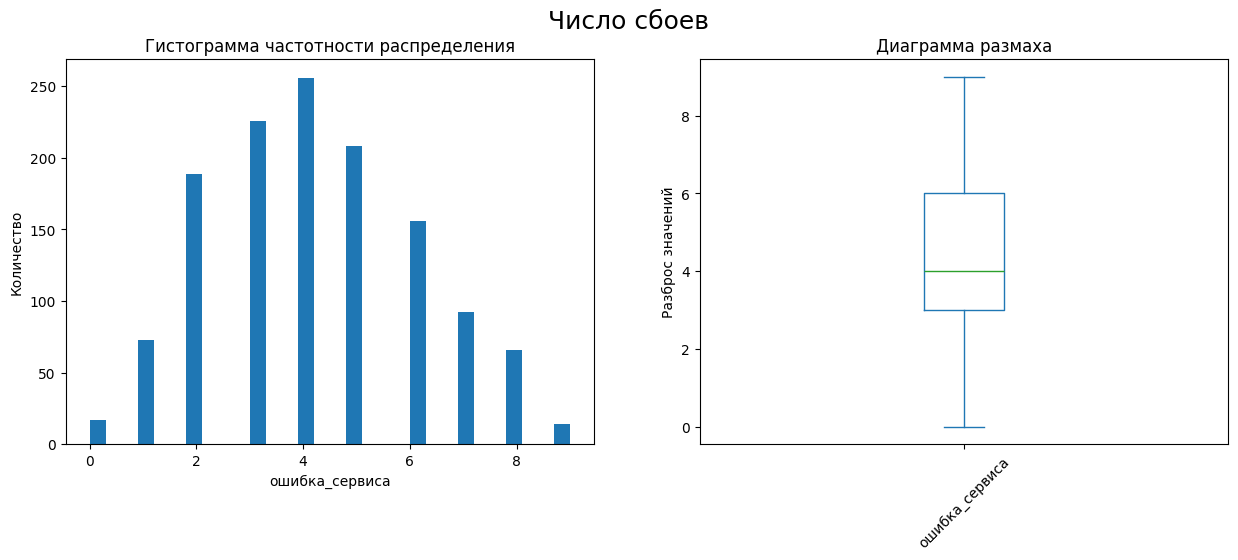

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Число сбоев', fontsize=18)
market_file['ошибка_сервиса'].plot(kind='hist', bins=30, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('ошибка_сервиса')
axes[0].set_ylabel('Количество')

market_file['ошибка_сервиса'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Данные графики показывают нам количество сбоев, которые коснулись покупателя во время посещения сайта. Варьируются данные от 0 до 9, а чаще всего среднее значение равно 4 сбоям. В данных выбрасов не обнаружено.

**8) 'Страниц за визит'**

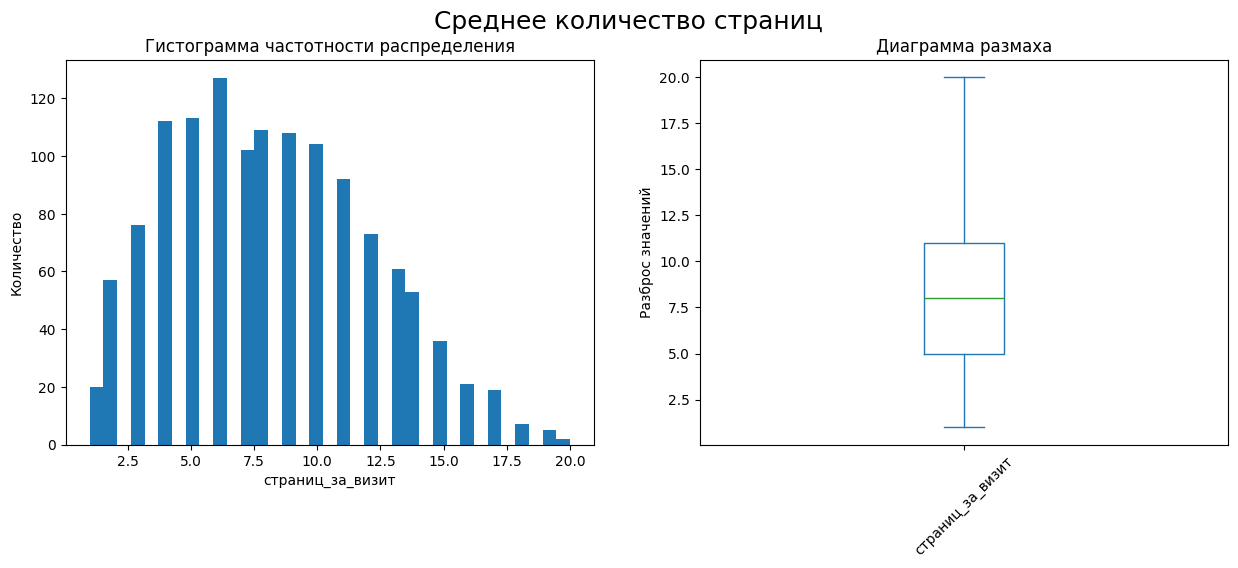

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Среднее количество страниц', fontsize=18)
market_file['страниц_за_визит'].plot(kind='hist', bins=35, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('страниц_за_визит')
axes[0].set_ylabel('Количество')

market_file['страниц_за_визит'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

На данных двух графиках мы видим среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. Выбрасов не имеется. Данные варьируются от 1 до 20 страниц на пользователя. В среднем большинство посетителей интернет магазина посещает 8 страниц за 3 месяца.

**9) 'Выручка'**

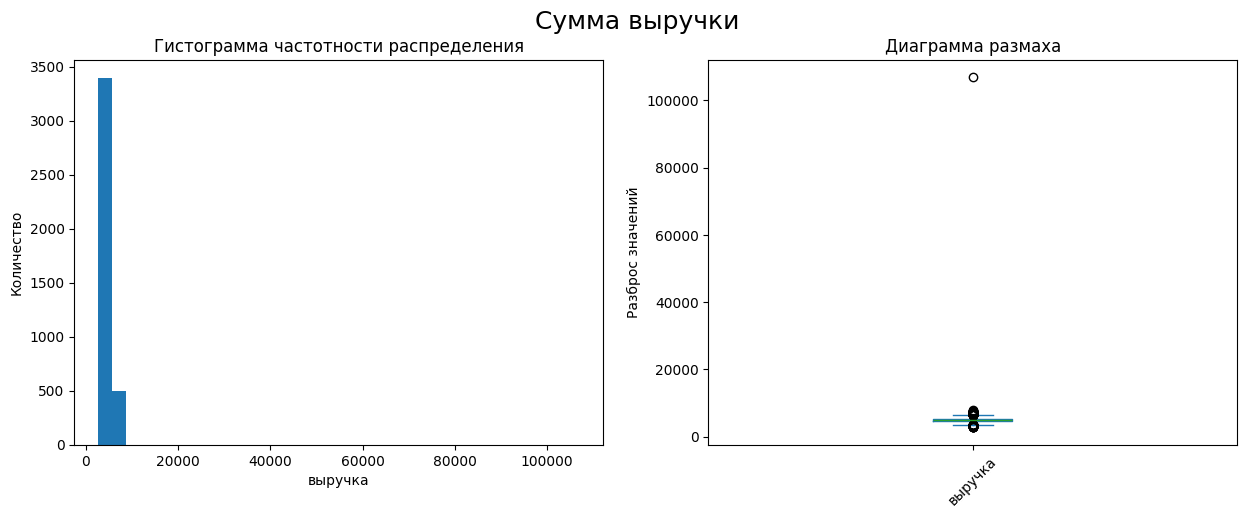

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Сумма выручки', fontsize=18)
market_money['выручка'].plot(kind='hist', bins=35, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('выручка')
axes[0].set_ylabel('Количество')

market_money['выручка'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

Диаграммы выглядят таким образом, из-за того, что в данных есть выбросы, поэтому найдем, удалим их и заново построим графики.

In [29]:
market_money.sort_values(by='выручка', ascending=False).head()

id         период   выручка
98    215380  текущий_месяц  106862.2
435   215493  текущий_месяц    7799.4
262   215435  текущий_месяц    7605.3
1481  215841  текущий_месяц    7557.0
2388  216144  текущий_месяц    7547.8

In [30]:
market_money = market_money.loc[market_money['выручка'] < 8000]

In [31]:
print(market_money['период'].value_counts())

период
предпредыдущий_месяц    1297
предыдущий_месяц        1297
текущий_месяц           1296
Name: count, dtype: int64


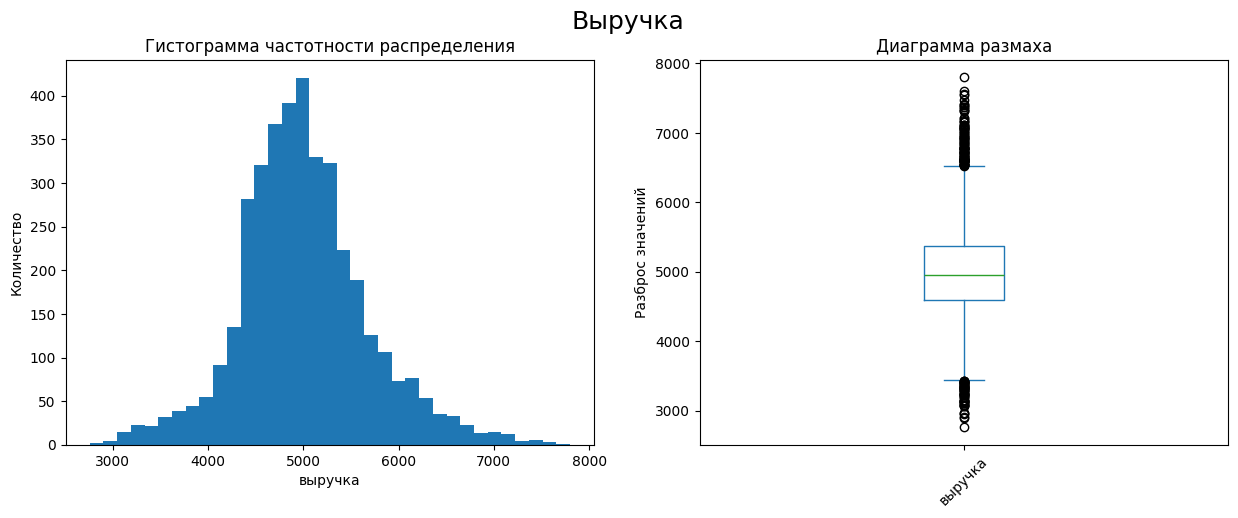

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Выручка', fontsize=18)
market_money['выручка'].plot(kind='hist', bins=35, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('выручка')
axes[0].set_ylabel('Количество')

market_money['выручка'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

In [33]:
display(market_money[['выручка']].describe().T)

count         mean         std     min     25%     50%     75%  \
выручка  3890.0  5007.541902  679.235737  2758.7  4592.0  4959.0  5363.0   

            max  
выручка  7799.4

Графики описывают данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Как мы можем заметить, большинство значений находится на промежуток от 4590 до 5360. Больше всего сумма выручки в среднем равна 5000. Гистограмма похожа на график нормального распределения. По диаграмме размаха мы также видим немного выбрасов. Не будем обрабатывать их т.к. их количество составляет немалую часть от исходных данных.

**10) 'Минут'**

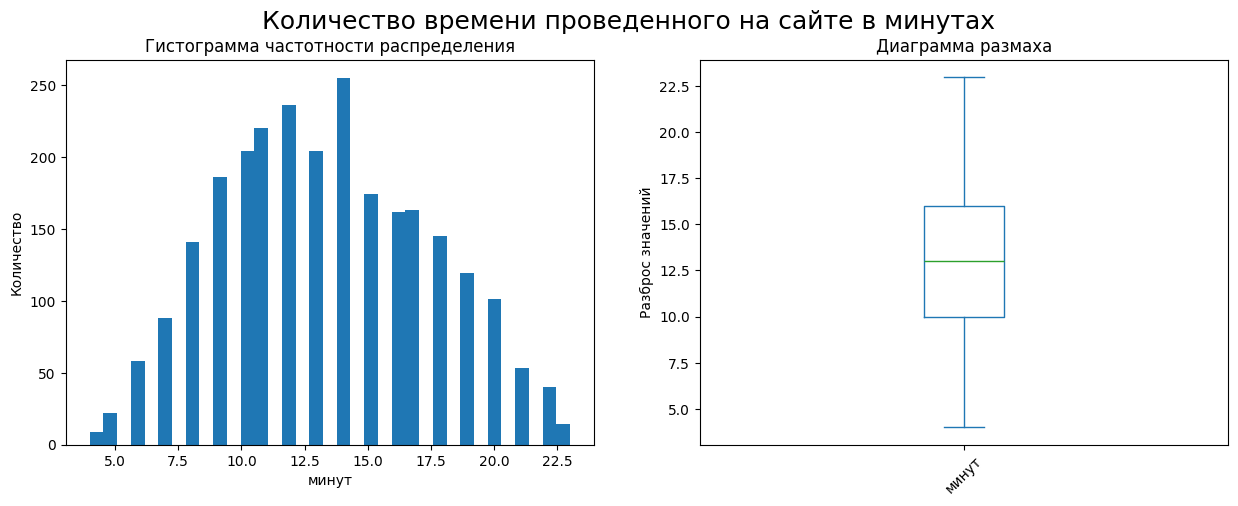

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Количество времени проведенного на сайте в минутах', fontsize=18)
market_time['минут'].plot(kind='hist', bins=35, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('минут')
axes[0].set_ylabel('Количество')

market_time['минут'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

In [35]:
display(market_time[['минут']].describe().T)

count       mean       std  min   25%   50%   75%   max
минут  2594.0  13.340401  4.081999  4.0  10.0  13.0  16.0  23.0

Гистограмма похожа на график нормального распределения. Большинство людей в среднем проводят на сайте магазина от 10 до 16 минут. Выбрасов в данных нет.

**11) 'Прибыль'**

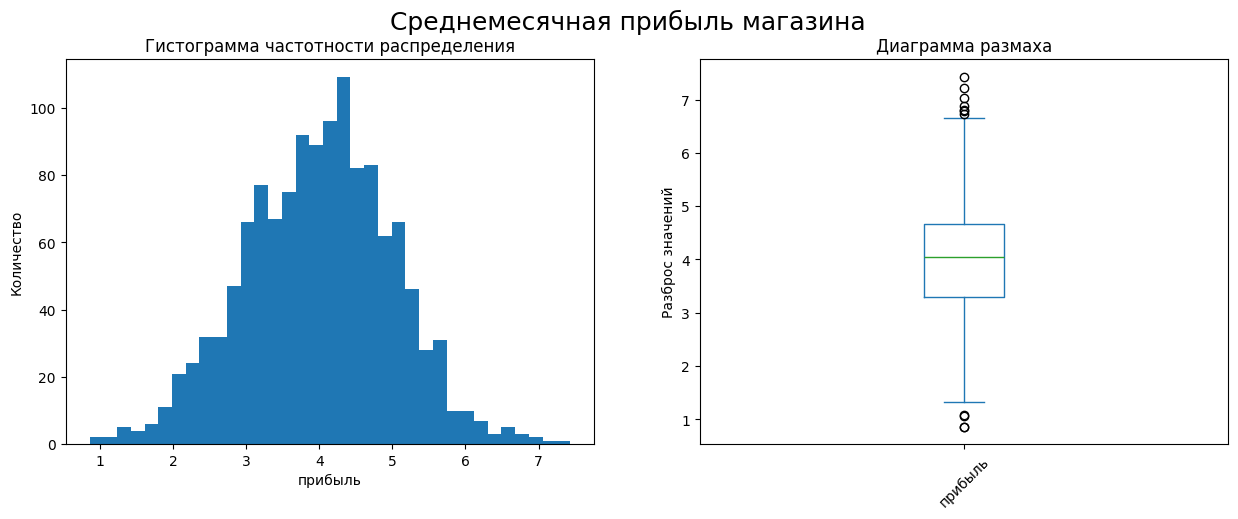

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Среднемесячная прибыль магазина', fontsize=18)
money['прибыль'].plot(kind='hist', bins=35, ax=axes[0])
axes[0].set_title('Гистограмма частотности распределения')
axes[0].set_xlabel('прибыль')
axes[0].set_ylabel('Количество')

money['прибыль'].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_ylabel('Разброс значений')
axes[1].set_title('Диаграмма размаха')
plt.show()

In [37]:
display(money[['прибыль']].describe().T)

count     mean       std   min  25%   50%   75%   max
прибыль  1297.0  3.99761  1.010813  0.86  3.3  4.04  4.67  7.43

Данная гистограмма также похожа на график нормального распределения со смещением вправо. Данные находятся на промежутке от 0.8 до 7.4 и большинство значений прибыли равно 4. Выбрасы так же как и выше мы не удаляем.

После произведем анализ категориальных признаков для датасетов market_file, market_money, market_time и money

**1) 'Покупательская активность'**

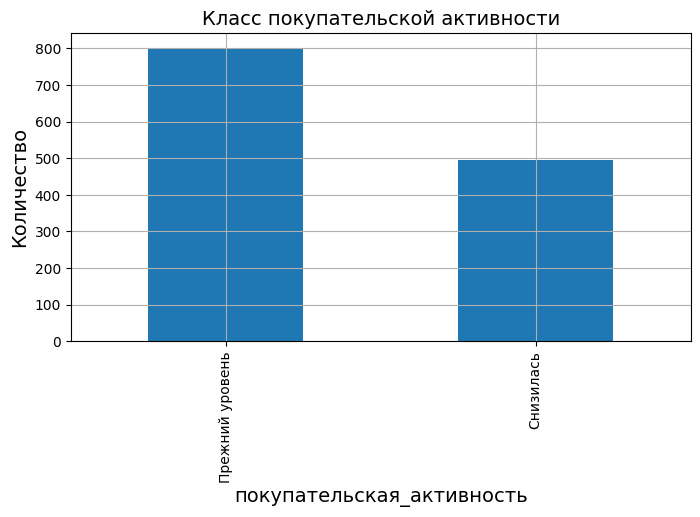

count                1297
unique                  2
top       Прежний уровень
freq                  802
Name: покупательская_активность, dtype: object

покупательская_активность
Прежний уровень    802
Снизилась          495
Name: count, dtype: int64


In [38]:
market_file['покупательская_активность'].value_counts().plot.bar(grid=True, figsize=(8, 4))
plt.xlabel('покупательская_активность', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Класс покупательской активности', fontsize=14)
plt.show()
print(market_file['покупательская_активность'].describe())
print()
print(market_file['покупательская_активность'].value_counts())

Как видно из графика покупательская активность на сайте по большей части у 802 пользователей осталась на прежнем уровне, а у 495 пользователей активность снизилась.

**2) 'Тип сервиса'**

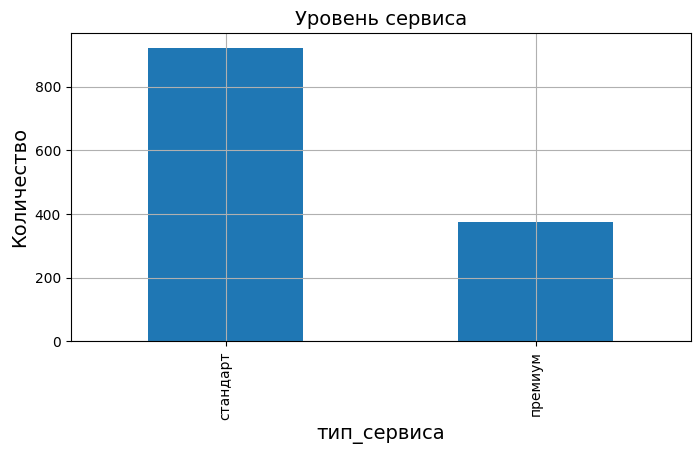

count         1297
unique           2
top       стандарт
freq           922
Name: тип_сервиса, dtype: object

тип_сервиса
стандарт    922
премиум     375
Name: count, dtype: int64


In [39]:
market_file['тип_сервиса'].value_counts().plot.bar(grid=True, figsize=(8, 4))
plt.xlabel('тип_сервиса', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Уровень сервиса', fontsize=14)
plt.show()
print(market_file['тип_сервиса'].describe())
print()
print(market_file['тип_сервиса'].value_counts())

У 922 пользователей интернет-магазина «В один клик» уровень сервиса 'Стандарт', и почти в 3 раза меньше пользователей с уровнем сервиса 'Премиум'.

**3) 'Разрешить сообщать'**

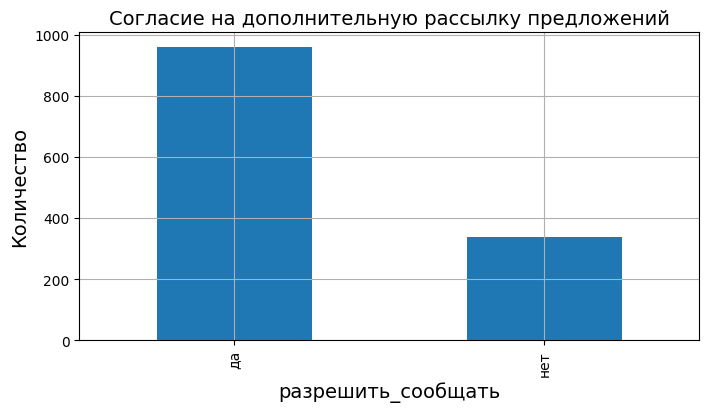

count     1297
unique       2
top         да
freq       959
Name: разрешить_сообщать, dtype: object

разрешить_сообщать
да     959
нет    338
Name: count, dtype: int64


In [40]:
market_file['разрешить_сообщать'].value_counts().plot.bar(grid=True, figsize=(8, 4))
plt.xlabel('разрешить_сообщать', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Согласие на дополнительную рассылку предложений', fontsize=14)
plt.show()
print(market_file['разрешить_сообщать'].describe())
print()
print(market_file['разрешить_сообщать'].value_counts())

На рассылку дополнительных предложения о товаре согасно почти в 3 раза больше пользователей интернет-магазина, чем не согласных.

**4) 'Популярная категория'**

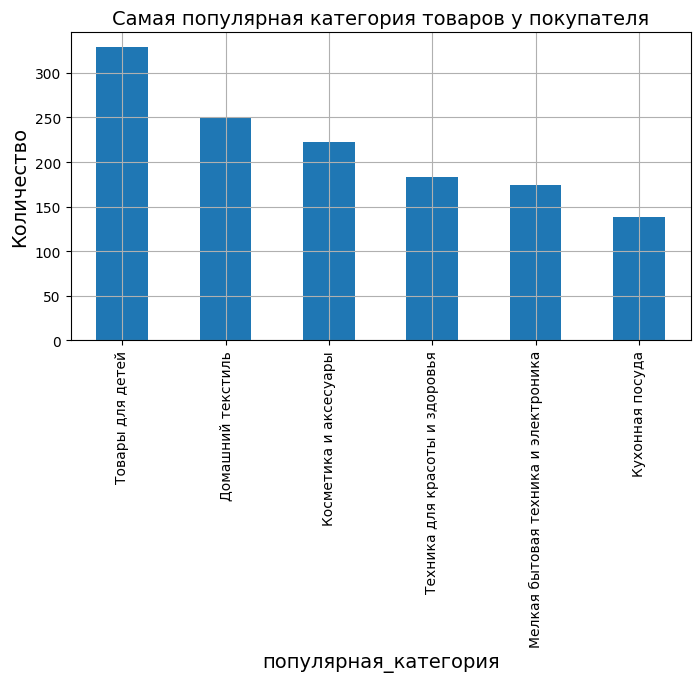

count                 1297
unique                   6
top       Товары для детей
freq                   329
Name: популярная_категория, dtype: object

популярная_категория
Товары для детей                        329
Домашний текстиль                       250
Косметика и аксесуары                   223
Техника для красоты и здоровья          183
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64


In [41]:
market_file['популярная_категория'].value_counts().plot.bar(grid=True, figsize=(8, 4))
plt.xlabel('популярная_категория', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Cамая популярная категория товаров у покупателя', fontsize=14)
plt.show()
print(market_file['популярная_категория'].describe())
print()
print(market_file['популярная_категория'].value_counts())

Как видно из данного графика 'Товары для детей' у покупателей пользуются самой большой популярностью, что не скажешь о кухонной посуде, которую заказывают почти в 2.5 раза меньше.

**5) 'Период, во время которого зафиксирована выручка'**

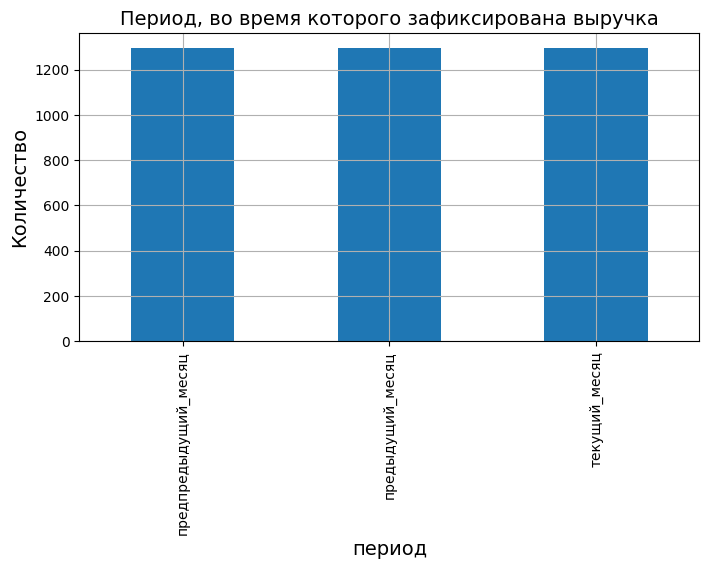

count                     3890
unique                       3
top       предпредыдущий_месяц
freq                      1297
Name: период, dtype: object

период
предпредыдущий_месяц    1297
предыдущий_месяц        1297
текущий_месяц           1296
Name: count, dtype: int64


In [42]:
market_money['период'].value_counts().plot.bar(grid=True, figsize=(8, 4))
plt.xlabel('период', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Период, во время которого зафиксирована выручка', fontsize=14)
plt.show()
print(market_money['период'].describe())
print()
print(market_money['период'].value_counts())

Как мы видим, выручка высчитывается за 3 последних месяца. В текущем месяце на 1 значение меньше, потому что ранее мы удалили один вырос из выручки, которая как раз была в текущем месяце.

**6) 'Период, во время которого зафиксировано общее время'**

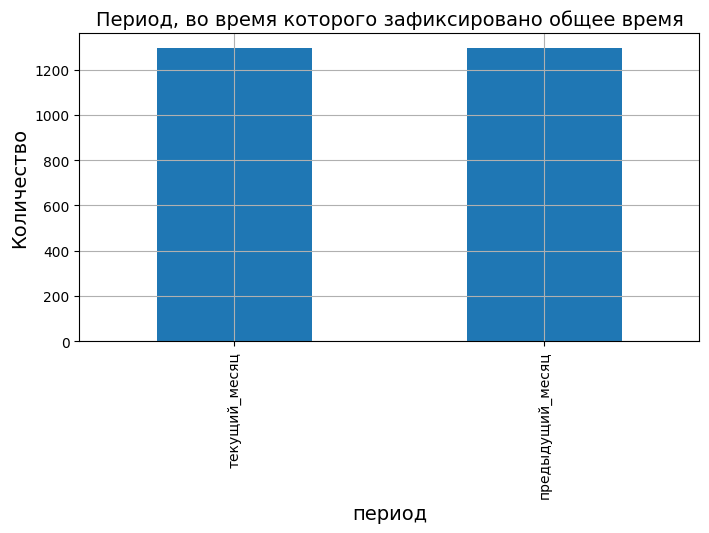

count              2594
unique                2
top       текущий_месяц
freq               1297
Name: период, dtype: object

период
текущий_месяц       1297
предыдущий_месяц    1297
Name: count, dtype: int64


In [43]:
market_time['период'].value_counts().plot.bar(grid=True, figsize=(8, 4))
plt.xlabel('период', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Период, во время которого зафиксировано общее время', fontsize=14)
plt.show()
print(market_time['период'].describe())
print()
print(market_time['период'].value_counts())

Как мы можем заметить, время, проведенное на сайте, указано за 2 последних месяца.

По итогу 3 шага можно сделать небольшой вывод.
В рамках проведенного исследования данных клиентов интернет-магазина, были выполнены следующие шаги и достигнуты ключевые результаты:

Отбор активных клиентов:
Были отобраны клиенты с покупательской активностью не менее трех месяцев. Исключены клиенты с выручкой, равной 0.0, так как у них низкая покупательская активность.

Определение признаков:

1. Количественные признаки:
В market_file: 'маркет_актив6мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит'
В market_money: 'выручка'
В market_time: 'минут'
В money: 'прибыль'

2. Категориальные признаки:
В market_file: 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория'.
В market_money и market_time: 'период'.

Анализ количественных признаков и посмотроение графиков — гистограммы частотности распределения и ящик с усами для каждого признака:

1) 'Маркет актив 6 мес': за последние 6 месяцев (маркет_актив6мес) показали маркетинговых коммуникаций находятся на промежутке от 3.7 до 4.9. Гистограмма похожа на график нормального распределения со смещением вправо. 2) У показалей 'Маркет актив тек мес' всего 3 уникальных значения (3, 4, 5). Чаще всего у польщователей и компании 4 коммуникации.
3) 'Длительность': большинство клиентов зарегистрированы на сайте от 410 до 806 дней. Гистограмма похожа на график нормального распределения. По диаграмме размаха выбрасов нет.
4) 'Акционные покупки': большая часть данных находится в диапазоне от 0.17 до 0.3, и в данных присутсивуют выбросы, которые мы не удаляем.
5) 'Средний просмотр категорий за визит': в среднем, клиенты просматривают 3 категории за визит.
6) 'Неоплаченные продукты штук квартал': большинство клиентов оставляют в корзине от 1 до 4 неоплаченных товаров.
7) 'Ошибка сервиса': среднее значение ошибок равно 4. В данных выбрасов не обнаружено.
8) 'Страниц за визит': данные варьируется от 1 до 20 страниц, и в среднем 8 страниц, просматриваемых за визит, за 3 месяца на пользователя. Выбрасов не имеется.
9) 'Выручка': большинство значений выручки находится в диапазоне от 4500 до 5300. Больше всего сумма выручки в среднем равна 5000. Гистограмма похожа на график нормального распределения. По диаграмме размаха мы также видим немного выбрасов, которые оставляем без обработки.
10) 'Минут': большинство клиентов проводят на сайте от 10 до 16 минут. Выбрасов в данных нет.
11) 'Прибыль': большинство значений прибыли находится в диапазоне от 0.8 до 7.4. Гистограмма похожа на график нормального распределения со смещением вправо. Выбрасы оставляем без обработки.

Анализ категориальных признаков и посмотрение графика:

1) 'Покупательская активность': у большинства клиентов (около 800) активность осталась на прежнем уровне, у 495 снизилась.
2) 'Тип сервиса': у 922 клиентов сервис 'Стандарт', у остальных 'Премиум'.
3) 'Разрешить сообщать': на рассылку согласных почти в 3 раза больше клиентов, чем не согласных.
4) 'Популярная категория': наиболее популярна категория 'Товары для детей', менее популярна 'Кухонная посуда'.
5) 'Период, во время которого зафиксирована выручка': выручка зафиксирована за последние 3 месяца.
6) 'Период, во время которого зафиксировано общее время': время зафиксировано за последние за 2 месяца.

Таким образом, проведенный анализ выявил важные особенности покупательской активности и взаимодействия клиентов с интернет-магазином. Эти данные могут быть использованы для дальнейшего улучшения маркетинговых стратегий, повышения качества сервиса и оптимизации взаимодействия с клиентами.

## Шаг 4. Объединение таблиц

Далее, объединим таблицы из файлов market_file, market_money, market_time.

Т.к. в двух таблицах находятся столбцы с одинаковыми названиями, переименуем их перед объединением, чтобы не запутаться в данных.

In [44]:
market_money = market_money.rename(columns={'период': 'период_деньги'})
market_time = market_time.rename(columns={'период': 'период_время'})
print(market_money.columns)
print(market_time.columns)

Index(['id', 'период_деньги', 'выручка'], dtype='object')
Index(['id', 'период_время', 'минут'], dtype='object')


Данные о выручке и времени на сайте находятся в одном столбце для всех периодов. Сделаем отдельные столбецы для каждого периода. Для этого сделаем небольгие преобразования с датасетами market_money и market_time

In [45]:
# Преобразуем таблицу market_money
market_money_pivot = market_money.pivot_table(index='id', 
                                              columns='период_деньги', 
                                              values='выручка', 
                                              aggfunc='first')

# Убираем многоуровневый индекс столбцов
market_money_pivot.columns = [f'выручка_{col}' for col in market_money_pivot.columns]

display(market_money_pivot.head(5))

выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
id                                                               
215349                        4472.0                    5216.0   
215350                        4826.0                    5457.5   
215351                        4793.0                    6158.0   
215352                        4594.0                    5807.5   
215353                        5124.0                    4738.5   

        выручка_текущий_месяц  
id                             
215349                 4971.6  
215350                 5058.4  
215351                 6610.4  
215352                 5872.5  
215353                 5388.5

In [46]:
# Преобразуем таблицу market_time
market_time_pivot = market_time.pivot_table(index='id', 
                                              columns='период_время', 
                                              values='минут', 
                                              aggfunc='first')

# Убираем многоуровневый индекс столбцов
market_time_pivot.columns = [f'минут_{col}' for col in market_time_pivot.columns]

display(market_time_pivot.head(5))

минут_предыдущий_месяц  минут_текущий_месяц
id                                                 
215349                      12                   10
215350                       8                   13
215351                      11                   13
215352                       8                   11
215353                      10                   10

Объединим получившиеся таблицы

In [47]:
merged_data = market_file.merge(market_money_pivot, on='id', how='left').merge(market_time_pivot, on='id', how='left')

# Проверка результата
display(merged_data.head(10))

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   
5  215354                 Снизилась    стандарт                 да   
6  215355                 Снизилась    стандарт                нет   
7  215356                 Снизилась    стандарт                 да   
8  215358                 Снизилась    стандарт                 да   
9  215360                 Снизилась     премиум                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   
5                 5.1                     3           431               0.23   
6                 4.7                     4           284               0.17   
7                 4.2                     4           192               0.14   
8                 4.7                     4           450               0.13   
9                 3.9                     3           623               0.35   

    популярная_категория  средний_просмотр_категорий_за_визит  \
0       Товары для детей                                    4   
1      Домашний текстиль                                    5   
2       Товары для детей                                    5   
3       Товары для детей                                    3   
4      Домашний текстиль                                    4   
5  Косметика и аксесуары                                    2   
6       Товары для детей                                    5   
7  Косметика и аксесуары                                    2   
8      Домашний текстиль                                    4   
9        Кухонная посуда                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   
5                                   3               7                 2   
6                                   1               6                 4   
7                                   2               1                 3   
8                                   2               6                 4   
9                                   1               4                 7   

   выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
0                        4472.0                    5216.0   
1                        4826.0                    5457.5   
2                        4793.0                    6158.0   
3                        4594.0                    5807.5   
4                        5124.0                    4738.5   
5                        4503.0                    5685.0   
6                        4749.0                    3263.0   
7                        4433.0                    4146.5   
8                        4727.0                    3488.0   
9                        5555.0                    5304.5   

   выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  
0                 4971.6                      12                   10

In [48]:
rows_with_nan = merged_data[merged_data.isna().any(axis=1)]
display(rows_with_nan)

id покупательская_активность тип_сервиса разрешить_сообщать  \
29  215380                 Снизилась     премиум                нет   

    маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
29                 1.7                     4           637               0.94   

              популярная_категория  средний_просмотр_категорий_за_визит  \
29  Техника для красоты и здоровья                                    3   

    неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
29                                   2               4                 7   

    выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
29                        5051.0                    6077.0   

    выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  
29                    NaN                      12                   14

Заменим значение NaN в столбце выручка_текущий_месяц на значение выручки как и в предыдущем месяце 6077.0

In [49]:
merged_data['выручка_текущий_месяц'] = merged_data['выручка_текущий_месяц'].fillna(6077.0)

In [50]:
display(merged_data[merged_data['id'] == 215380])

id покупательская_активность тип_сервиса разрешить_сообщать  \
29  215380                 Снизилась     премиум                нет   

    маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
29                 1.7                     4           637               0.94   

              популярная_категория  средний_просмотр_категорий_за_визит  \
29  Техника для красоты и здоровья                                    3   

    неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
29                                   2               4                 7   

    выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
29                        5051.0                    6077.0   

    выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  
29                 6077.0                      12                   14

Итак, в шаге 4 мы объединенили таблицы и преобразовали данные

Для выполнения данной задачи были использованы три исходных таблицы: market_file.csv, market_money.csv, market_time.csv. Каждая из них содержит различные аспекты данных о рынке, включая основные данные, информацию о выручке и времени на сайте.

Особенностью данных о выручке и времени на сайте является то, что они расположены в одном столбце для всех периодов (предпредыдущий_месяц, предыдущий_месяц, текущий_месяц). Для того чтобы лучше структурировать данные, столбцы с данными о выручке и времени мы переобразовали таким образом, чтобы каждый период (предпредыдущий_месяц, предыдущий_месяц, текущий_месяц) имел свой собственный столбец в итоговой таблице. И после, объединили все 3 таблицы по уникальному id покупателя. В результате получилась таблица, где каждая строка соответствует определенному id покупателя, а столбцы содержат выручку для каждого из трех периодов.

## Шаг 5. Корреляционный анализ

Далее, проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Целевым признаком укажем 'покупательскую активность'.

Количественные признаки в таблице merged_data: 'id', 'маркет_актив6мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц'.

Для проведения корреляционного анализа признаков в нашей таблице merged_data мы построим тепловую карту.

Для оценки взаимосвязей следует проводить корреляционный анализ отдельно для каждой категории на основе целевого признака. В нашем случае имеется две категории пользователей: те, чья активность снизилась, и те, чья активность осталась на прежнем уровне.

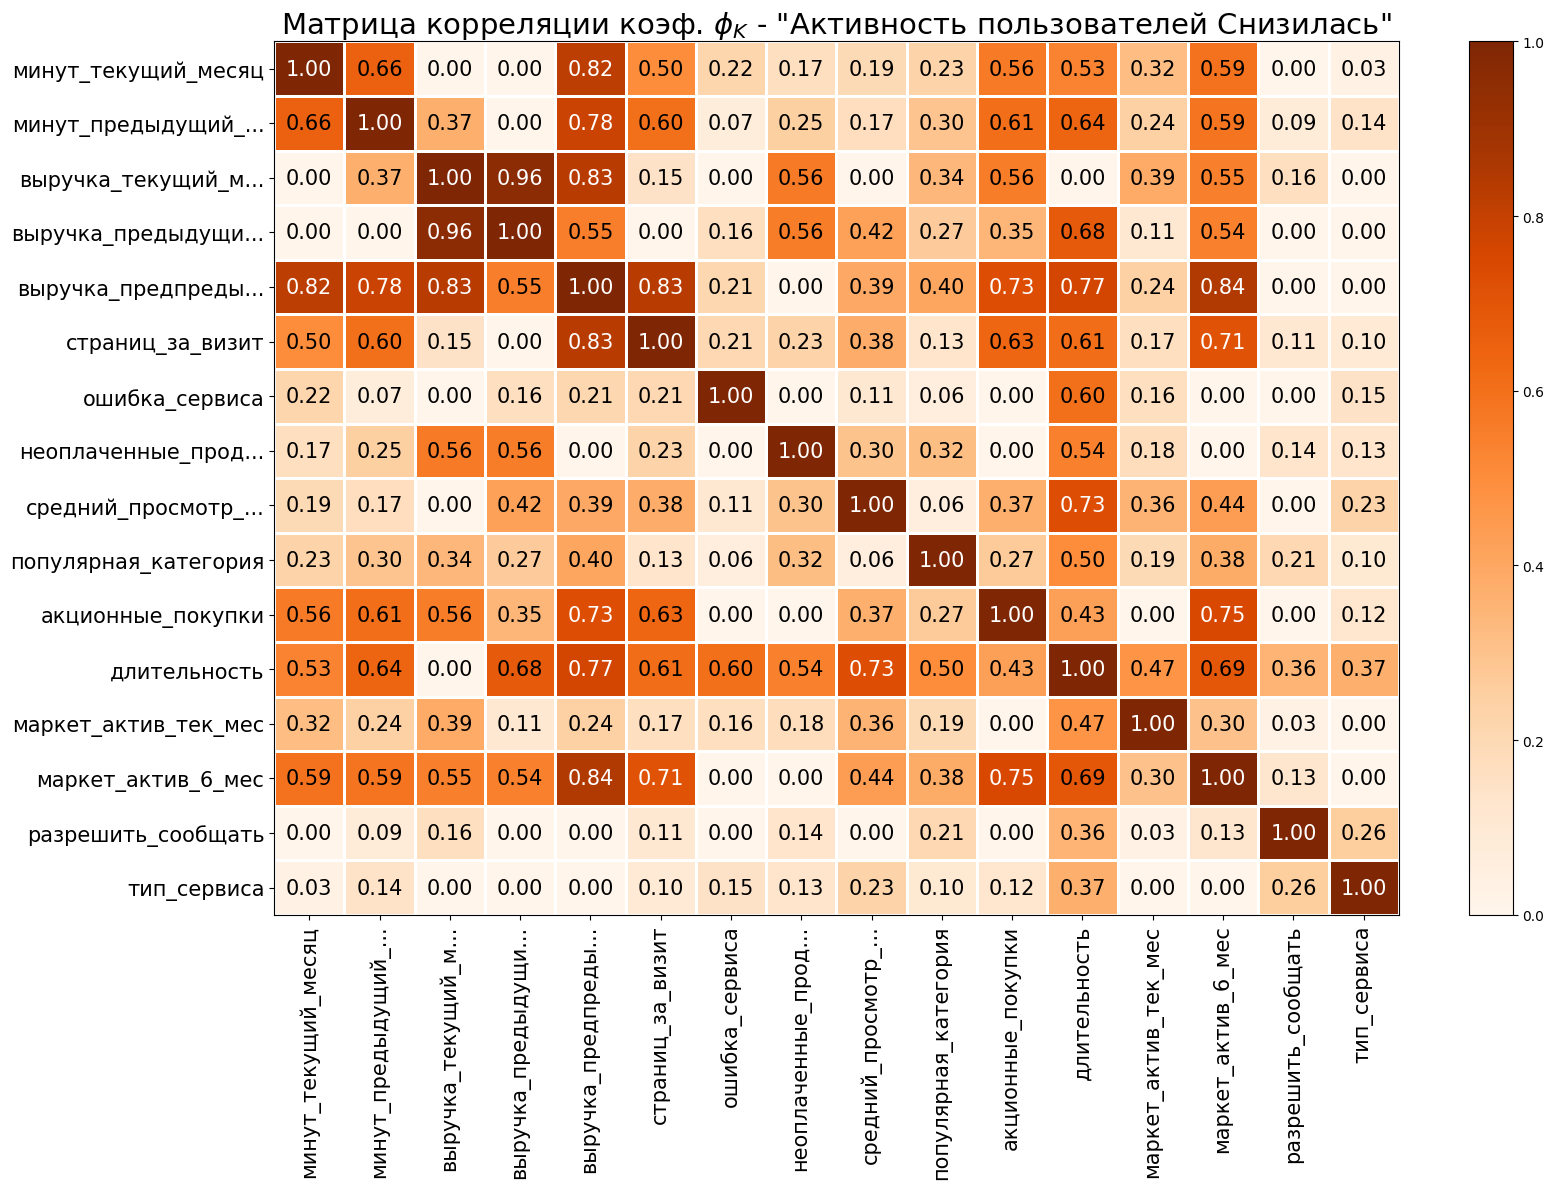

In [51]:
# покупательская активность Снизилась
# построим матрицу корреляции коэффициента Фи'
interval_cols = merged_data.drop('id', axis=1).select_dtypes(include='number').columns.tolist()
phik_down_category = phik_matrix(merged_data[merged_data['покупательская_активность']=='Снизилась'].drop(['id', 'покупательская_активность'],axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_down_category.values,
    x_labels=phik_down_category.columns,
    y_labels=phik_down_category.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'Матрица корреляции коэф. $\phi_K$ - "Активность пользователей Снизилась"',
    fontsize_factor=1.5,
    figsize=(17, 12)
)

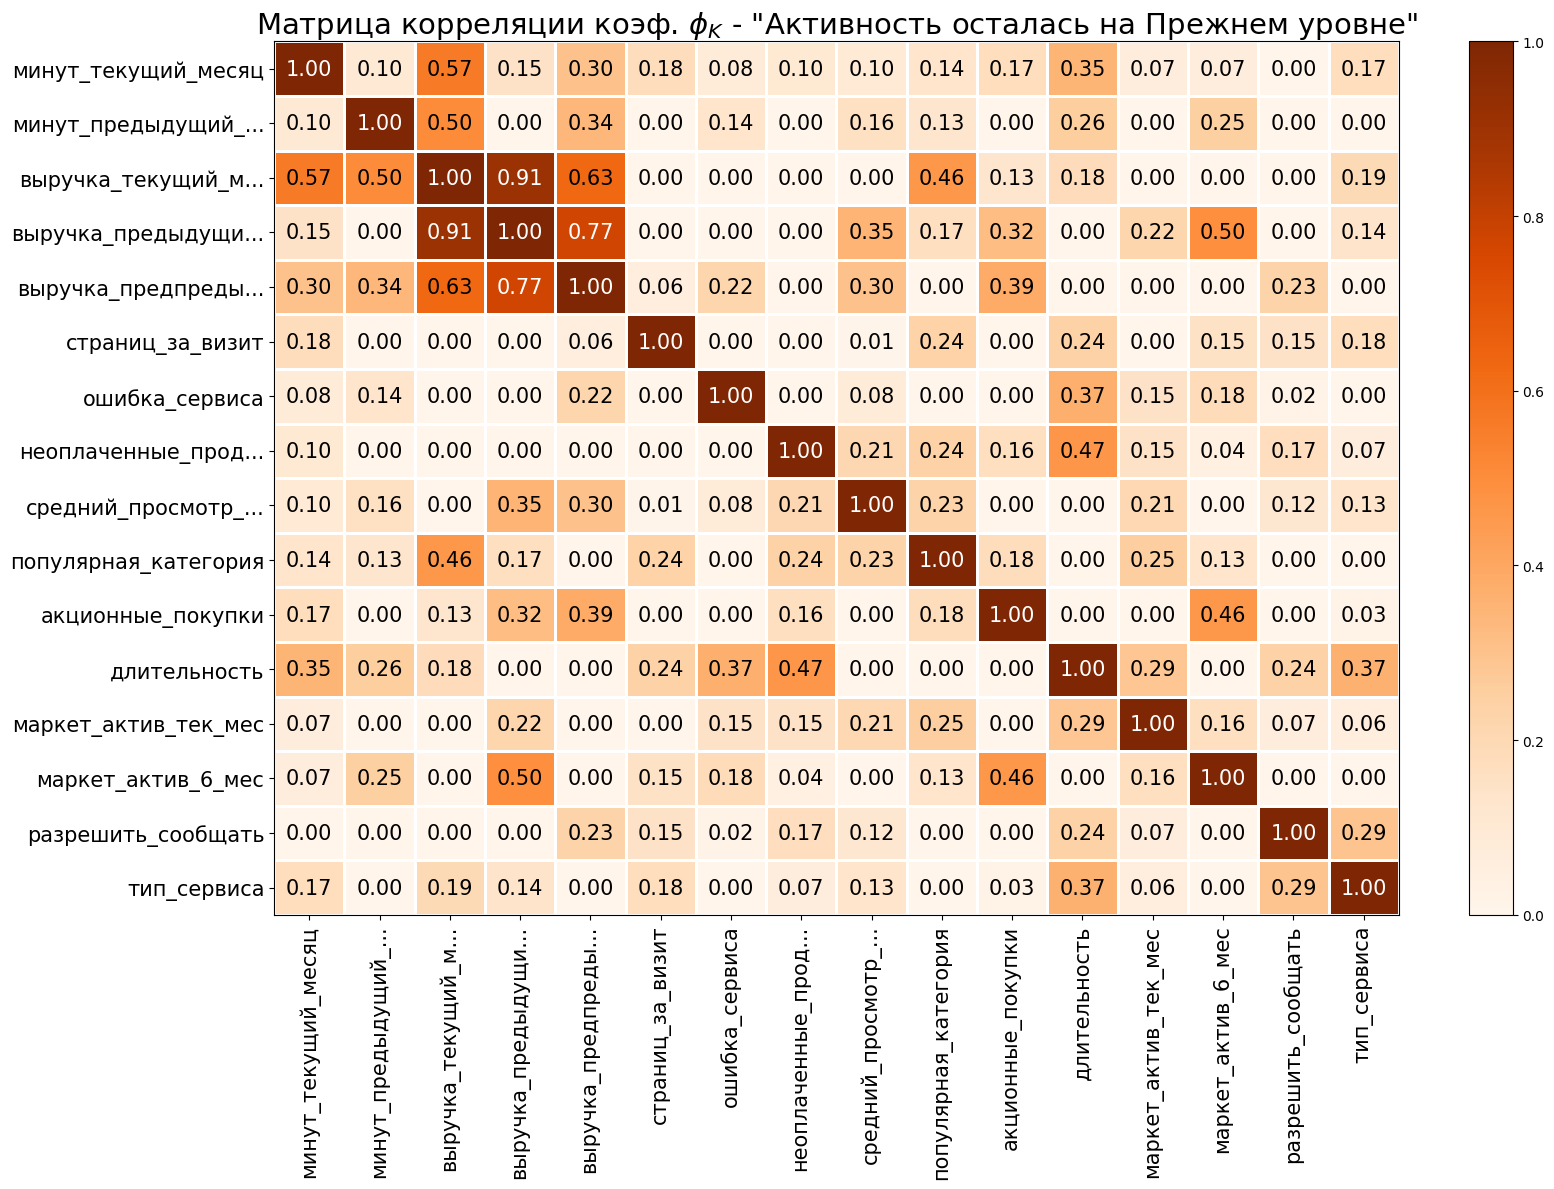

In [52]:
# покупательская активность осталась на Прежнем уровне
# построим матрицу корреляции коэффициента Фи'
phik_still_category = phik_matrix(merged_data[merged_data['покупательская_активность']=='Прежний уровень'].drop(['id', 'покупательская_активность'],axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_still_category.values,
    x_labels=phik_still_category.columns,
    y_labels=phik_still_category.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'Матрица корреляции коэф. $\phi_K$ - "Активность осталась на Прежнем уровне"',
    fontsize_factor=1.5,
    figsize=(17, 12)
)

Мультиколлинеарность - это состояние, при котором две или более независимых переменных в регрессионной модели сильно коррелируют друг с другом. Это может затруднить оценку влияния каждой переменной на зависимую переменную и привести к нестабильным оценкам коэффициентов регрессии. Обычно, высокие значения (близкие к 1 или -1) в корреляционной матрице могут указывать на мультиколлинеарность. Избавимся от признаков с уровнем корреляционной связи свыше 0.8. Такая связь наблюдается между "выручкой предпредыдущий месяц", "выручкой предыдущий месяц" и "выручкой текущий месяц" с другими признаками. Попробуем удалить признак "выручка_предыдущий_месяц" и проверим опять значения.

In [53]:
merged_data = merged_data.drop('выручка_предыдущий_месяц', axis=1)
merged_data = merged_data.drop('выручка_предпредыдущий_месяц', axis=1)

Заново построим тепловые карты и посмотрим как изменились значения

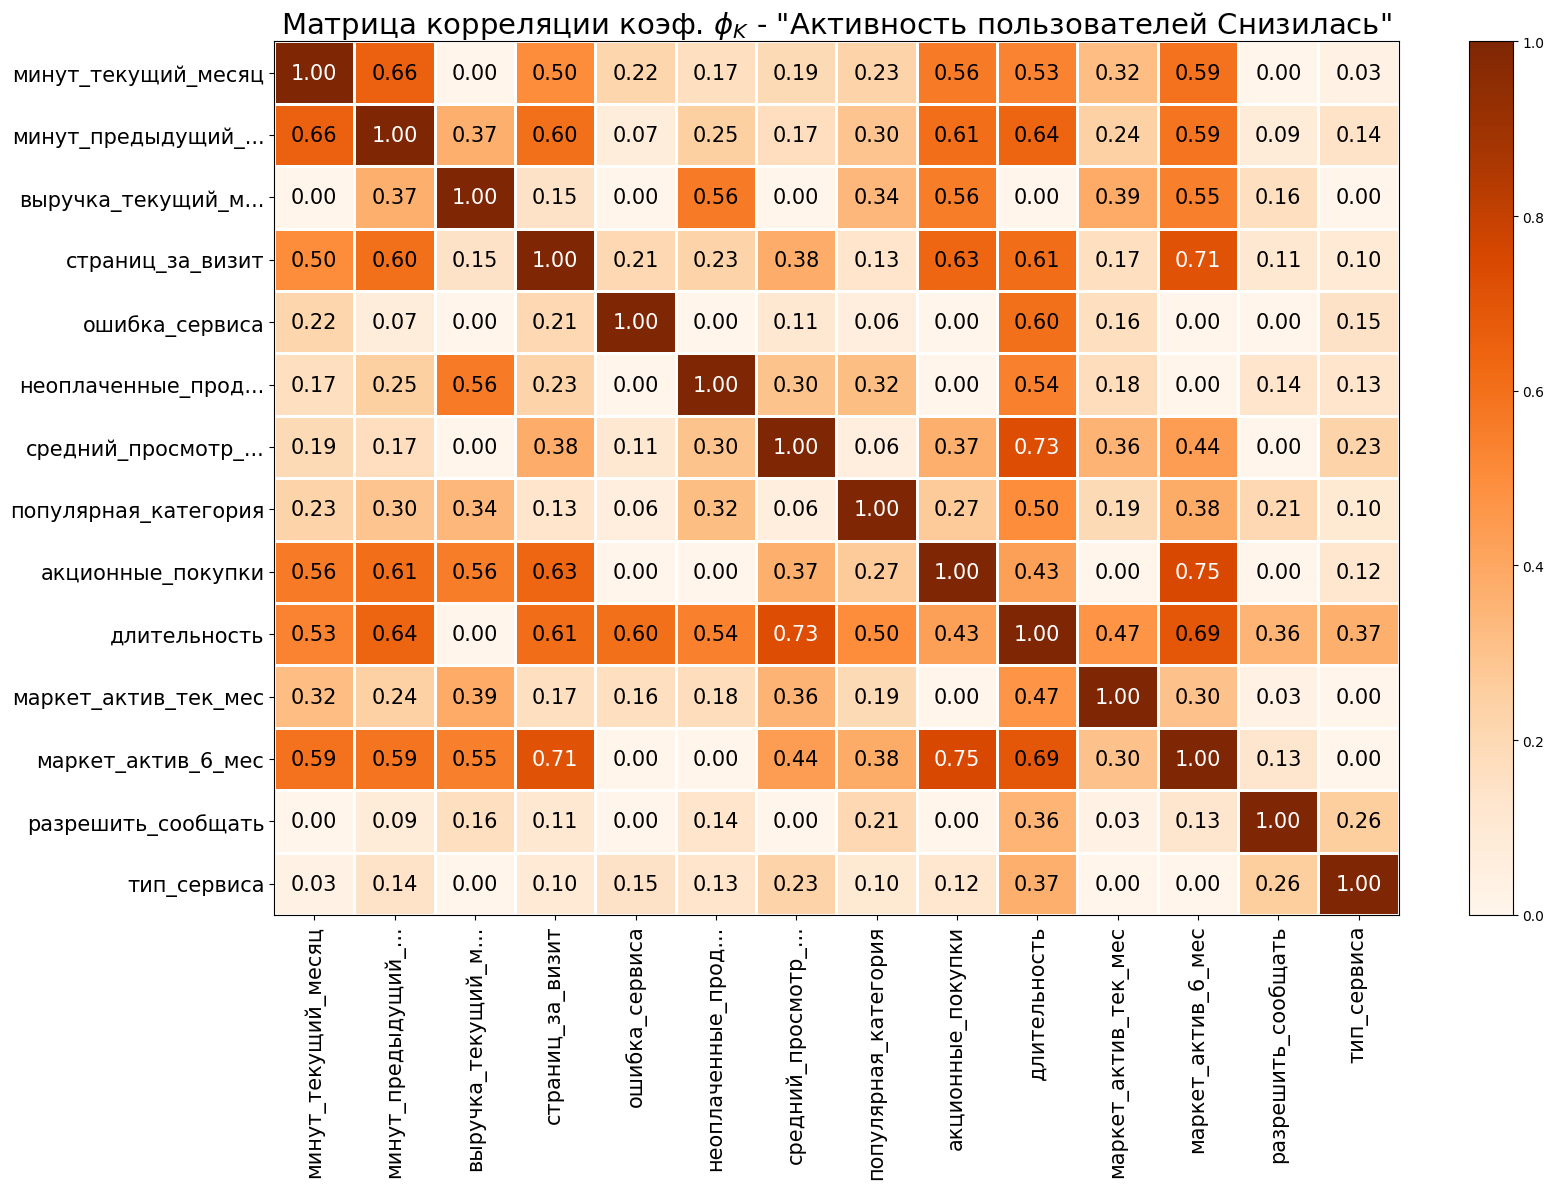

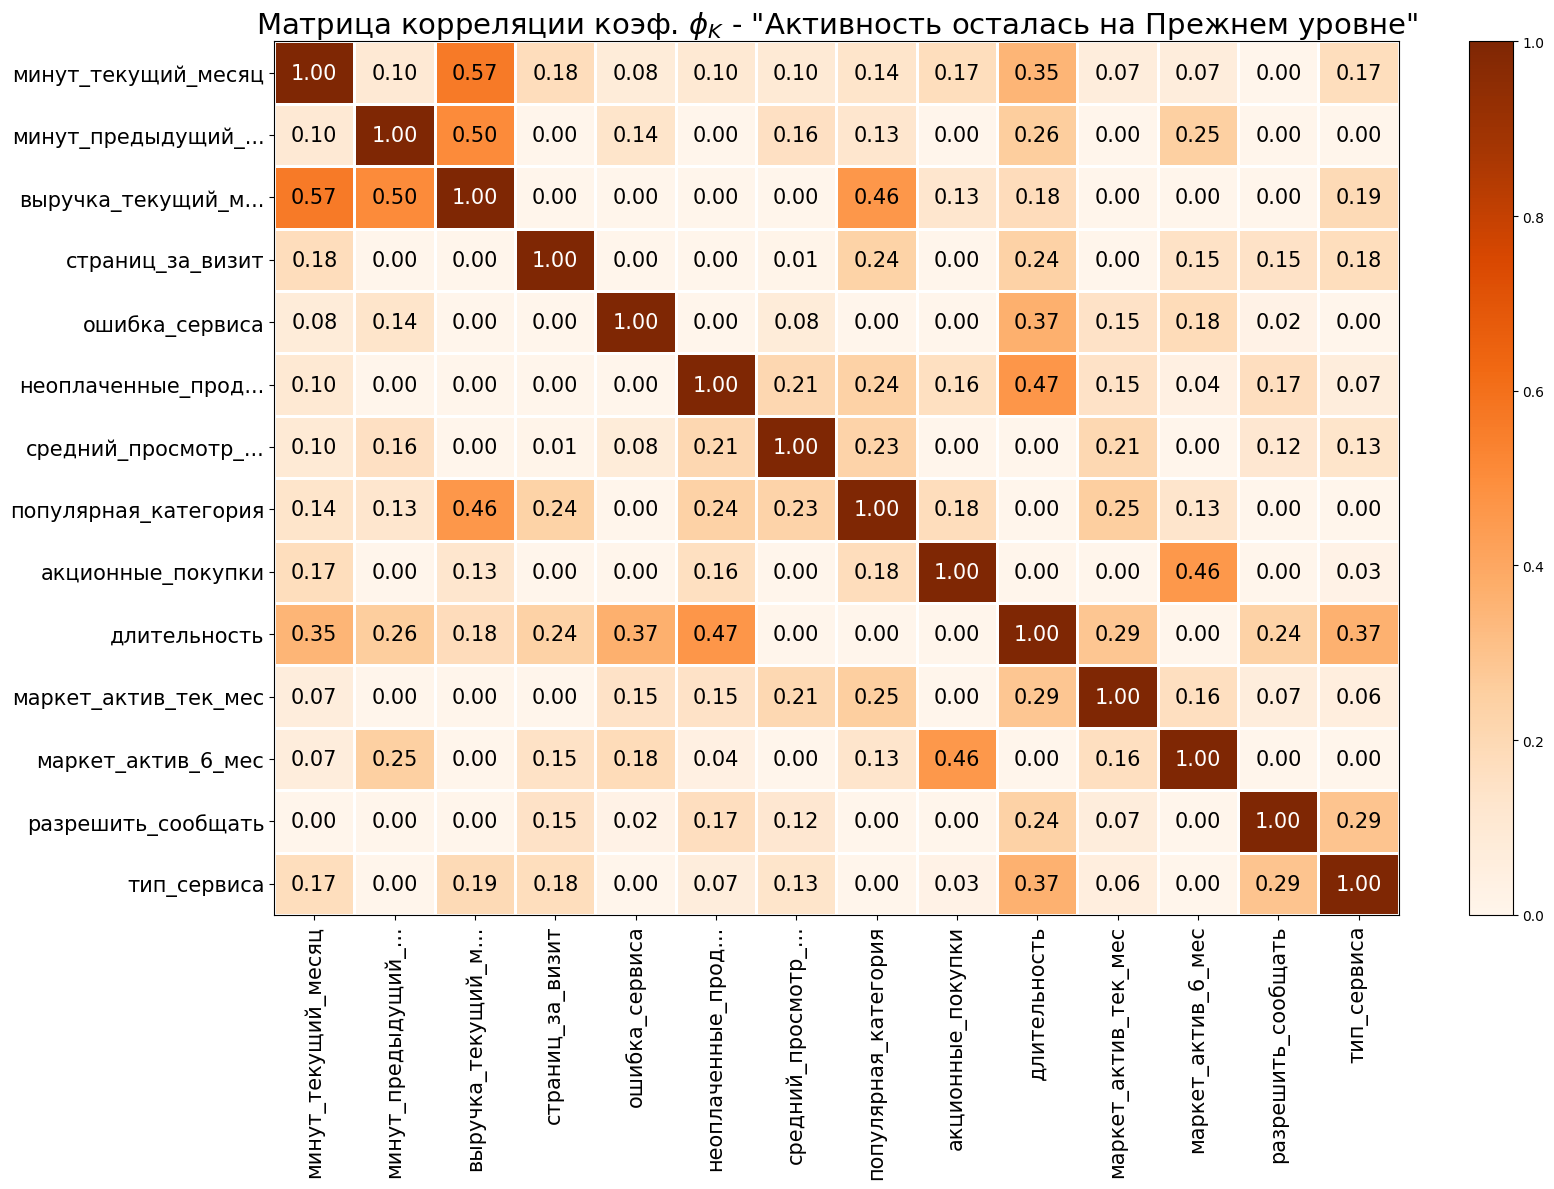

In [54]:
# покупательская активность Снизилась
# построим матрицу корреляции коэффициента Фи'
interval_cols = merged_data.drop('id', axis=1).select_dtypes(include='number').columns.tolist()
phik_down_category = phik_matrix(merged_data[merged_data['покупательская_активность']=='Снизилась'].drop(['id', 'покупательская_активность'],axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_down_category.values,
    x_labels=phik_down_category.columns,
    y_labels=phik_down_category.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'Матрица корреляции коэф. $\phi_K$ - "Активность пользователей Снизилась"',
    fontsize_factor=1.5,
    figsize=(17, 12)
)

# покупательская активность осталась на Прежнем уровне
# построим матрицу корреляции коэффициента Фи'
phik_still_category = phik_matrix(merged_data[merged_data['покупательская_активность']=='Прежний уровень'].drop(['id', 'покупательская_активность'],axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_still_category.values,
    x_labels=phik_still_category.columns,
    y_labels=phik_still_category.index,
    vmin=0, vmax=1, color_map='Oranges',
    title=r'Матрица корреляции коэф. $\phi_K$ - "Активность осталась на Прежнем уровне"',
    fontsize_factor=1.5,
    figsize=(17, 12)
)

Судя по тепловой карте и графикам, самая высокая связь у признаков "маркет_актив6месяцев" с признаками "страниц_за_визит" и "длительность". У "длительности" также высокая корредяция с "средний_просмотр_категорий_за_визит". Остальные признаки либо связаны умеренной связью, или же значение кореляции незначительное.

Перепроверим еще раз, есть ли мультиколлинеарность в данных или нет. Для этого, расчитаем значения VIF. Variance Inflation Factor (VIF): VIF измеряет, насколько сильно одна независимая переменная объясняется другими независимыми переменными. Значение VIF выше 10 может указывать на сильную мультиколлинеарность. Найдем эти значения для наших признаков

In [55]:
num_cols = list(merged_data.select_dtypes(exclude='object').columns)
merged_data_tmp = merged_data[num_cols].drop(columns=['id'])

# Добавляем константу к данным
X = add_constant(merged_data_tmp)

# Вычисляем VIF для каждого признака
vif_data = pd.Series([variance_inflation_factor(X.values, i) 
                      for i in range(X.shape[1])], 
                     index=X.columns)

display(vif_data)

const                                  145.049818
маркет_актив_6_мес                       1.209124
маркет_актив_тек_мес                     1.042816
длительность                             1.094912
акционные_покупки                        1.184664
средний_просмотр_категорий_за_визит      1.178116
неоплаченные_продукты_штук_квартал       1.161511
ошибка_сервиса                           1.079222
страниц_за_визит                         1.373141
выручка_текущий_месяц                    1.050773
минут_предыдущий_месяц                   1.473119
минут_текущий_месяц                      1.271979
dtype: float64

Полученные результаты помогают нам понять, насколько каждый признак линейно связан с другими признаками. Значения VIF интерпретируются следующим образом: т.к. все значения VIF близки к 1, то признаки имеют минимальную или отсутствующую линейную зависимость с другими признаками. Можно сказать, что признаки не создают проблемы мультиколлинеарности.

По итогу 5 шага можно сделать небольшой вывод:

Для оценки взаимосвязей мы построили тепловую карту корреляций. Корреляционный анализ был проведен отдельно для каждой категории пользователей на основе целевого признака, где выделены две категории: пользователи, чья активность снизилась, и пользователи, чья активность осталась на прежнем уровне.

Также, в ходе проведенного анализа данных была осуществлена проверка на наличие мультиколлинеарности среди независимых признаков. Основной целью данной работы было выявление потенциально проблемных признаков, которые могут негативно влиять на стабильность и интерпретируемость регрессионной модели.

Мультиколлинеарность возникает, когда две или более независимых переменных в регрессионной модели сильно коррелируют друг с другом, что может привести к нестабильным оценкам коэффициентов регрессии. Высокие значения корреляции (близкие к 1 или -1) могут указывать на мультиколлинеарность. Признаки с уровнем корреляционной связи выше 0.8 были удалены, в частности, "выручка_предыдущий_месяц" и 'выручка_предпредыдущий_месяц'.

Для оценки степени взаимосвязи между признаками были использованы два основных инструмента - коэффициенты корреляции и коэффициенты инфляции дисперсии (VIF).

Анализ корреляционной матрицы показал, что большинство значений коэффициентов корреляции находятся в допустимых пределах, что указывает на отсутствие значительной линейной зависимости между признаками. Лишь в редких случаях значения корреляции приближаются к 0.7. Также, в результате вычислений VIF было обнаружено, что большинство значений находятся в очень большой близости к 1, что свидетельствует о низком уровне мультиколлинеарности. Это подтверждает, что наши признаки практически не коррелируют друг с другом и не создают значительных проблем для построения регрессионной модели.

В заключении можно сказать, что наш набор данных в целом не страдает от значительной мультиколлинеарности. Признаки, использованные в модели, демонстрируют низкую степень взаимной корреляции, что является положительным результатом для дальнейшего построения и использования регрессионной модели. Таким образом, мы можем заключить, что выбранные признаки подходят для модели, и она будет устойчивой и интерпретируемой.

## Шаг 6. Использование пайплайнов

Для начала, перед обучением моделей, нам необходимо подготовить данные, и в этом нам помогут пайплайны

Сначала обозначим, какие данные требуют масштабирования, а какие — кодирования.
Разобьем данные на количественные и категориальные:
Два признака: 'тип_сервиса' и 'разрешить_сообщать' — нужно кодировать с помощью OneHotEncoder. Один признак: 'популярная_категория' — нужно кодировать с помощью OrdinalEncoder. Остальные количественные признаки нужно масштабировать. Целевой признак — 'покупательская_активность'.

In [56]:
ohe_columns = ['популярная_категория', 'разрешить_сообщать']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'выручка_текущий_месяц',
               'страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц']

Теперь начнём создавать пайплайн. Для работы с пайплайном используем модуль sklearn.pipeline.

In [57]:
# Определение переменной RANDOM_STATE и TEST_SIZE
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [58]:
# создадим пайплайн для OneHotEncoder:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

In [59]:
# cоздадим пайплайн для OrdinalEncoder:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [60]:
# Преобразователи для числовых данных
num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

Объединяем шаги подготовки. Далее применим новый инструмент ColumnTransformer — он объединяет операции по подготовке данных. В нашей задаче это кодирование и масштабирование.

In [61]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [62]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Далее разобьем данные на тренировочную и тестовую выборки:

In [63]:
X = merged_data.drop(['id', 'покупательская_активность'], axis=1)
y = merged_data['покупательская_активность']

# Разделение данных на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

X_train.shape, X_test.shape

# Преобразование целевой переменной
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Преобразование данных
X_train_scaled = data_preprocessor.fit_transform(X_train)
X_test_scaled = data_preprocessor.transform(X_test)

print(X_train_scaled.shape) 
print(X_test_scaled.shape)

(972, 18)
(325, 18)


Для начала, выберем подходящую для задачи метрику. В дальнейшем, используем эту метрику при подборе гиперпараметров. Выбор метрики зависит от конкретных целей и особенностей задачи классификации. Рассмотрим аргументы в пользу использования метрик F1-score и ROC-AUC.

F1-Score: F1-score полезен, когда классы в данных несбалансированы, потому что это гармоническое среднее Precision и Recall, что позволяет учитывать как ложноположительные, так и ложноотрицательные ошибки. Также F1-score дает единое значение, которое объединяет точность и полноту, что делает его удобным для оценки моделей. Плюс, F1-score будет хорошим выбором, если наша задача требует особого внимания к точности и полноте по какому-то конкретному классу.

ROC-AUC (Receiver Operating Characteristic - Area Under the Curve): ROC-AUC оценивает способность модели различать между положительными и отрицательными классами, независимо от порога, что полезно для общего понимания качества модели. eceiver Operating Characteristic - Area Under the Curve): Оценивает способность модели различать между классами. ROC-AUC измеряет площадь под ROC-кривой, которая показывает отношение между долей верно классифицированных положительных и долей ложноположительных результатов при изменении порогового значения. Также ROC-AUC рассматривает все возможные пороги классификации, давая полное представление о производительности модели. И хотя AUC может быть более чувствителен к несбалансированным данным, он все еще полезен, так как показывает, насколько хорошо модель различает классы.

Выбор между F1-score и ROC-AUC зависит от конкретной задачи: Если наша цель — минимизировать оба типа ошибок и наши данные несбалансированы, F1-score может быть более подходящим. Если нам нужно оценить общую способность модели различать классы и мы хотим учитывать производительность при всех возможных порогах, ROC-AUC может быть лучшим выбором.

В связи с этим, выберем метрику ROC-AUC для дальнейшего использования.

Далее обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC().

Опишем немного каждую модель:

1)KNeighborsClassifier: K-ближайших соседей (KNN) — это простой алгоритм, который хранит все доступные случаи и классифицирует новые случаи на основе меры сходства (например, расстояния). Этот метод чаще всего используется для задач классификации и регрессии. Гиперпараметры модели, которые мы используем: n_neighbors, weights, p.

2)DecisionTreeClassifier: Дерево решений — это модель, которая предсказывает значение целевой переменной, обучаясь простым правилам принятия решений, выведенным из данных признаков. Гиперпараметры модели, которые мы используем: max_depth, min_samples_split, min_samples_leaf.

3)LogisticRegression: Логистическая регрессия используется для моделирования вероятности принадлежности класса. Чаще всего применяется для бинарной классификации. Гиперпараметры модели, которые мы используем: penalty, C, solver.

4)SVC (Support Vector Classifier): SVM (машины опорных векторов) — это мощный и гибкий метод для задач классификации. Алгоритм находит гиперплоскость, которая максимально разделяет классы. Гиперпараметры модели, которые мы используем: C, kernel.

**1) KNeighborsClassifier()**

Для выбора лучшей модели, мы используем пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно.

In [ ]:
# Включение подавления предупреждений
warnings.filterwarnings('ignore')

param_grid_knn = {
    'model': [KNeighborsClassifier()],
    'model__n_neighbors': range(2, 20),
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

randomized_search_knn = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid_knn, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=100,
    n_jobs=-1
)
randomized_search_knn.fit(X_train, y_train)

In [65]:
print('Лучшая модель и её параметры:\n\n', randomized_search_knn.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_knn.best_score_)
y_train_best_knn = randomized_search_knn.best_score_
print(randomized_search_knn.best_score_)

# Проверяем работу модели на тестовой выборке
y_test_pred_proba_knn = randomized_search_knn.predict_proba(X_test)[:, 1]
# Рассчитываем прогноз на тестовых данных
print(f'Метрика ROC-AUC на тестовой выборке у KNeighborsClassifier(): {roc_auc_score(y_test, y_test_pred_proba_knn)}')
print ('Метрика лучшей модели на тренировочной выборке:', y_train_best_knn)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

Наш код обучил KNeighborsClassifier с лучшими найденными параметрами и вывел, что метрика модели на тренировочной выборке: 0.90895

**2) DecisionTreeClassifier()**

Произведем все те же шаги, что делали выше, и также найдем значения ROC-AUC на тестовой выборке.

In [66]:
param_grid_dt = { 
    'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'model__max_depth': range(2, 20),
    'model__min_samples_split': range(2, 20),
    'model__min_samples_leaf': range(1, 20),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

randomized_search_dt = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid_dt, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=100,
    n_jobs=-1
)
randomized_search_dt.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_dt.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_dt.best_score_)
y_train_best_dt = randomized_search_dt.best_score_
# Проверяем работу модели на тестовой выборке
y_test_pred_proba_dt = randomized_search_dt.predict_proba(X_test)[:, 1]
# Рассчитываем прогноз на тестовых данных
print(f'Метрика ROC-AUC на тестовой выборке у DecisionTreeClassifier(): {roc_auc_score(y_test, y_test_pred_proba_dt)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

In [67]:
print ('Метрика лучшей модели на тренировочной выборке:', y_train_best_dt)

Метрика лучшей модели на тренировочной выборке: 0.8777908321544686


Наш код обучил DecisionTreeClassifier() с лучшими найденными параметрами и вывел метрику лучшей модели на тренировочной выборке: 0.87779

**3) LogisticRegression()**

In [68]:
param_grid_lr = {
    'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')], 
    'model__penalty': ['l1', 'l2'],
    'model__C': np.logspace(-3, 3, 20),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

randomized_search_lr = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid_lr, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=100,
    n_jobs=-1
)
randomized_search_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_lr.best_score_)
y_train_best_lr = randomized_search_lr.best_score_
# Проверьте работу модели на тестовой выборке
# Рассчитайте прогноз на тестовых данных
y_test_pred_proba_lr = randomized_search_lr.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba_lr)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

In [69]:
print ('Метрика лучшей модели на тренировочной выборке:', y_train_best_lr)

Метрика лучшей модели на тренировочной выборке: 0.9003825602461966


Наш код обучил LogisticRegression() с лучшими найденными параметрами и метрику лучшей модели на тренировочной выборке: 0.90038

**4) SVC() (Support Vector Classifier)**

In [70]:
param_grid_svc = {
    'model': [SVC(probability=True, random_state=RANDOM_STATE, kernel='poly')], 
    'model__degree': range(2, 3),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

randomized_search_svc = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid_svc, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_iter=100,
    n_jobs=-1
)
randomized_search_svc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_svc.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_svc.best_score_)
y_train_best_svc = randomized_search_svc.best_score_
# Проверяем работу модели на тестовой выборке
y_test_pred_proba_svc = randomized_search_svc.predict_proba(X_test)[:, 1]
# Рассчитываем прогноз на тестовых данных
print(f'Метрика ROC-AUC на тестовой выборке у SVC(): {roc_auc_score(y_test, y_test_pred_proba_svc)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                            

In [71]:
print ('Метрика лучшей модели на тренировочной выборке:', y_train_best_svc)

Метрика лучшей модели на тренировочной выборке: 0.8927795944705036


Наш код обучил SVC() с лучшими найденными параметрами и вывел значение ROC-AUC = 0.89277 на тестовой выборке.

Также, построим график ROC-кривой для каждой модели для тестовой выборки. Тестовую выбрку мы применим к лучшей модели, для контроля переобучения.

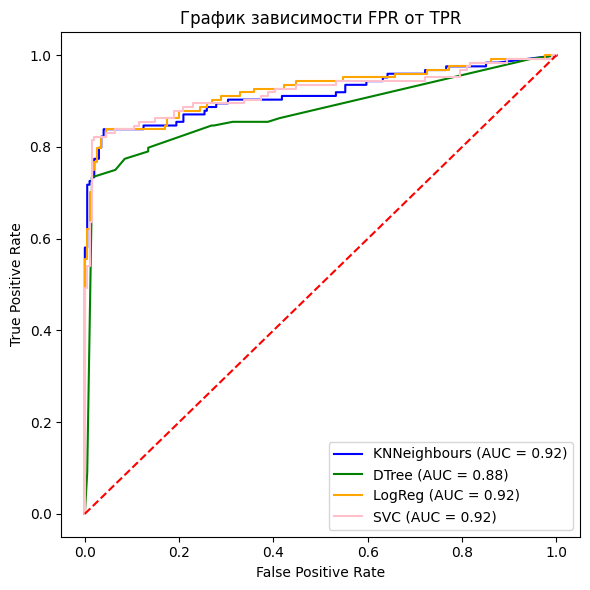

In [72]:
# KNearestNeighbours
fpr_test_kn, tpr_test_kn, thresholds_kn = roc_curve(y_test_encoded, y_test_pred_proba_knn)
roc_auc_test_kn  = auc(fpr_test_kn, tpr_test_kn)

# DecisionTree
fpr_test_dt, tpr_test_dt, thresholds_dt = roc_curve(y_test_encoded, y_test_pred_proba_dt)
roc_auc_test_dt  = auc(fpr_test_dt, tpr_test_dt)

# Logistic Regression
fpr_test_lr, tpr_test_lr, thresholds_lr = roc_curve(y_test_encoded, y_test_pred_proba_lr)
roc_auc_test_lr  = auc(fpr_test_lr, tpr_test_lr)

# SVM
fpr_test_svc, tpr_test_svc, thresholds_svc = roc_curve(y_test_encoded, y_test_pred_proba_svc)
roc_auc_test_svc  = auc(fpr_test_svc, tpr_test_svc)

fig = plt.figure(figsize=(6,6))

plt.plot(fpr_test_kn, tpr_test_kn, color='blue', label='KNNeighbours (AUC = %0.2f)' % roc_auc_test_kn)
plt.plot(fpr_test_dt, tpr_test_dt, color='green', label='DTree (AUC = %0.2f)' % roc_auc_test_dt)
plt.plot(fpr_test_lr, tpr_test_lr, color='orange', label='LogReg (AUC = %0.2f)' % roc_auc_test_lr)
plt.plot(fpr_test_svc, tpr_test_svc, color='pink', label='SVC (AUC = %0.2f)' % roc_auc_test_svc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График зависимости FPR от TPR')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

Модели сравним по результатам кросс-валидации (randomized_search.best_score_).
Значения получились следующие:

- KNeighborsClassifier() - Метрика лучшей модели на тренировочной выборке: 0.90895
- DecisionTreeClassifier() - Метрика лучшей модели на тренировочной выборке: 0.87779
- LogisticRegression() - Метрика лучшей модели на тренировочной выборке: 0.90038
- SVC() - Метрика лучшей модели на тренировочной выборке: 0.89278
На основе приведенных значений метрики ROC-AUC на тренировочной выборке для различных моделей, можно сделать следующие выводы: Все модели показывают высокие значения ROC-AUC, что свидетельствует о хорошей способности различать положительные и отрицательные классы. KNeighborsClassifier() показал наибольшее значение 0.90895. LogisticRegression() также показал высокое значение 0.90038

Следовательно, **KNeighborsClassifier() можно считать лучшей моделью** среди рассмотренных на основании ROC-AUC на тренировочной выборке, но разница между LogisticRegression() и KNeighborsClassifier небольшая.

В итоге, после 6 шага в нашей работы, можно сделать следующее обобщение:

Перед обучением моделей были подготовлены данные с использованием пайплайнов. В ходе подготовки данных использовался ColumnTransformer. Данные были разделены на количественные и категориальные признаки. Два признака: 'популярная_категория' и 'разрешить_сообщать' — закодированы с помощью OneHotEncoder. Один признак: 'тип_сервиса' — закодирован с помощью OrdinalEncoder. Остальные количественные признаки были масштабированы. Целевой признак — 'покупательская_активность'. Затем данные также были разбиты на тренировочную и тестовую выборки.

После, были обучены четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них был выполнен подбор гиперпараметров. Для оценки моделей была выбрана метрика ROC-AUC. Она оценивает способность модели различать между положительными и отрицательными классами, независимо от порога, что полезно для общего понимания качества модели. ROC-AUC измеряет площадь под ROC-кривой, которая показывает отношение между долей верно классифицированных положительных и долей ложноположительных результатов при изменении порогового значения.

Для каждой модели были использованы пайплайны и инструменты подбора гиперпараметров для выбора лучшей модели по результатам кросс-валидации и также был построен график ROC-кривой для каждой модели для тестовой выборки.

KNeighborsClassifier: 0.90895 по результатам кросс-валидации.   
DecisionTreeClassifier: 0.87779 по результатам кросс-валидации.  
LogisticRegression: 0.90038 по результатам кросс-валидациие.  
SVC: 0.89278 по результатам кросс-валидации.  

На основании приведенных значений для различных моделей можно сделать следующие выводы: Все модели показали высокие значения ROC-AUC, что указывает на их хорошую способность различать положительные и отрицательные классы. Модель **KNeighborsClassifier()** показала наибольшее значение 0.90895. Модель LogisticRegression также продемонстрировала высокое значение 0.90038. Таким образом, KNeighborsClassifier() можно считать лучшей моделью среди рассмотренных.

## Шаг 7. Анализ важности признаков

Далее, оценим важность признаков для нашей лучшей модели и построим график важности с помощью метода SHAP. SHAP значения помогают понять вклад каждого признака в предсказание модели. Cоздадим и отобразим график важности признаков для модели SVC.

  0%|          | 0/30 [00:00<?, ?it/s]

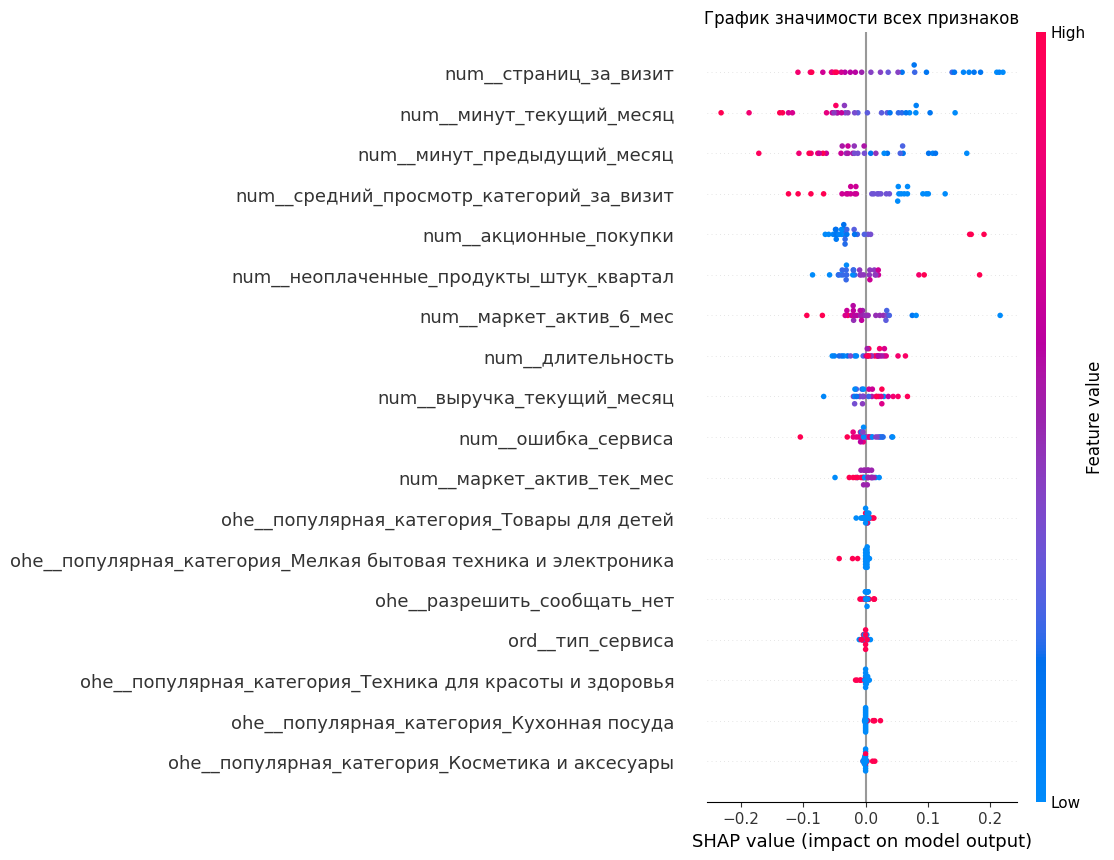

In [73]:
# Используем 30 примеров для SHAP
X_train_sample = X_train.sample(n=30, random_state=RANDOM_STATE)
X_test_sample = X_test.sample(n=30, random_state=RANDOM_STATE)

X_train_p = pd.DataFrame(randomized_search_knn.best_estimator_.steps[0][1].fit_transform(X_train_sample),
                         columns=randomized_search_knn.best_estimator_.steps[0][1].get_feature_names_out())
X_test_p = pd.DataFrame(randomized_search_knn.best_estimator_.steps[0][1].transform(X_test_sample),
                         columns=randomized_search_knn.best_estimator_.steps[0][1].get_feature_names_out())

model = randomized_search_knn.best_estimator_.steps[1][1]

# Использование KernelExplainer для генерации SHAP значений
explainer = shap.KernelExplainer(model.predict_proba, X_train_p)
shap_values = explainer.shap_values(X_test_p)

# Построение summary plot
plt.figure(figsize=(20, 8))
plt.title('График значимости всех признаков')
shap.summary_plot(shap_values[:, :, 1], X_test_p, plot_size=(5,10))
plt.show()

Активность пользователя снизится, если

- будет маленькое количество просмотренных страниц за визит
- пользователь будет проводить недолгое время на сайте;
- среднее число просмотренных категорий за визит будет очень маленькое;
- будет мало маркетинговых коммуникаций с клиентом

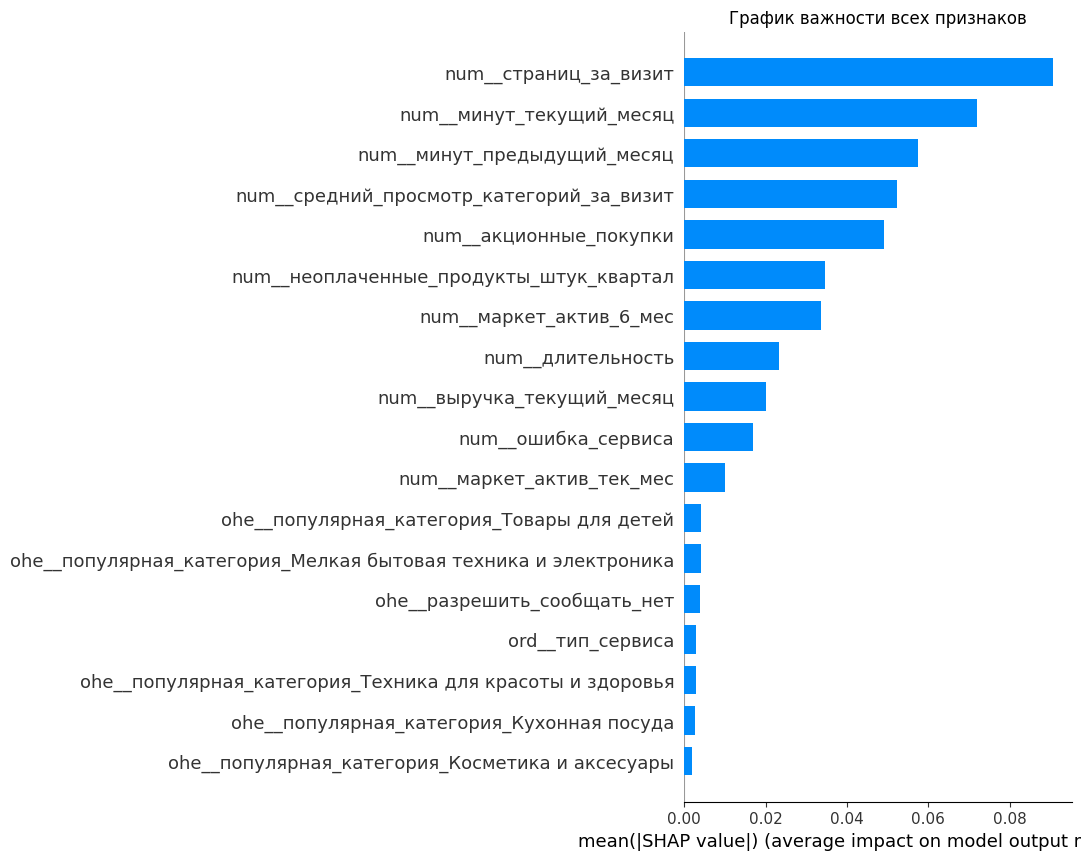

In [74]:
# Построение bar plot для важности признаков
plt.title('График важности всех признаков')
shap.summary_plot(shap_values[:, :, 1], X_test_p, plot_type='bar', plot_size=(5,10))
plt.show()

На основании графиков, мы можем заметить, что

Признаки, больше всего связанные с активностью клиентов:
- страниц за визит (среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца)
- минут предыдущий месяц (значение времени, проведённого на сайте, в минутах)
- минут текущий месяц (значение времени, проведённого на сайте, в минутах)

Признаки, меньше всего связанные с активностью клиентов:
- разрешить сообщать (информация о том, можно ли присылать покупателю дополнительные предложения о товаре.)
- тип сервиса (уровень сервиса, «премиум» и «стандарт»)
- маркет актив тек месяц (количество маркетинговых коммуникаций в текущем месяце)
- популярная категория (кухонная посуда и косметика и аксессуары)

После 7 шага нашей работы мы можем сделать небольшие выводы.

Мы провели анализ важности признаков для нашей лучшей модели и построили график важности с помощью метода SHAP. SHAP значения помогают понять вклад каждого признака в предсказание модели.

На основании графиков, мы видим

Активность пользователя снизится, если: 1) будет маленькое количество просмотренных страниц за визит; 2) пользователь будет проводить недолгое время на сайте; 3) среднее число просмотренных категорий за визит будет очень маленькое; 4) будет мало маркетинговых коммуникаций с клиентом

Признаки, мало значимые для модели: 1) Страниц за визит, 2) Минут предыдущий месяц, 3) Минут текущий месяц
Признаки, сильнее всего влияющие на целевой признак: 1) Разрешить сообщать, 2) Тип сервиса, 3) Маркет актив тек месяц, 4) Популярная категория (Кухонная посуда, Косметика и аксессуары)

Мы можем использовать эти наблюдения при моделировании и принятии бизнес-решений.

Например, поскольку признаки, такие как "страниц за визит", "минут предыдущий месяц" и "минут текущий месяц" оказывают наибольшее влияние на активность клиентов, маркетинговые кампании могут быть настроены для увеличения этих показателей. Например, улучшение пользовательского интерфейса и контента сайта может стимулировать клиентов просматривать больше страниц за визит.

Также, хорошим решение может стать улучшение клиентского сервиса. Поскольку тип сервиса (премиум/стандарт) имеет меньшую связь с активностью клиентов, можно провести более глубокий анализ, чтобы понять, как различные уровни сервиса влияют на лояльность и удовлетворенность клиентов. Разработка программ лояльности, ориентированных на клиентов с высоким уровнем активности, может помочь удерживать таких клиентов и стимулировать их дальнейшую активность.

К тому же данные о том, можно ли присылать покупателю дополнительные предложения, могут быть использованы для улучшения стратегий взаимодействия. Компаниям следует учитывать предпочтения клиентов относительно коммуникаций, чтобы не перегружать их ненужной информацией и избегать отписок.

Анализ важности признаков с помощью метода SHAP предоставил ценные сведения о том, какие факторы наиболее сильно влияют на активность клиентов. Эти наблюдения могут быть использованы для оптимизации маркетинговых стратегий, улучшения клиентского сервиса и взаимодействия, что в конечном итоге может привести к увеличению вовлеченности и лояльности клиентов.

## Шаг 8. Сегментация покупателей

Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей.

Для начала, устанавим порог (threshold = 0.8), который используется для классификации предсказанных вероятностей модели. В нашем случае, если предсказанная вероятность того, что покупатель снизит свою активность, больше 0.8, то модель считает, что активность покупателя снизится.

In [75]:
threshold_high = 0.8

После, мы использум нашу лучшую модель, которую нашли выше, чтобы предсказать вероятности класса "Снижение" для данных, которые были предварительно обработаны.

In [76]:
best_model = randomized_search_knn.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]
prediction_flags_high = predictions > threshold_high
# Преобразуем prediction_flags в индексы
indices_high_decline = np.where(prediction_flags_high)[0] # Выберем только те данные для которых модель предсказала снижение

In [77]:
# Выберем только те данные для которых модель предсказала снижение
df_high_decline = merged_data.loc[indices_high_decline]
#Объединяем таблицы
df_high_decline = df_high_decline.merge(money, on='id', how='left')
# Проверим, что добавился столбец
display(df_high_decline.head(5))

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215352                 Снизилась    стандарт                нет   
2  215356                 Снизилась    стандарт                 да   
3  215364                 Снизилась     премиум                 да   
4  215367                 Снизилась     премиум                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 5.1                     3          1064               0.94   
2                 4.2                     4           192               0.14   
3                 4.3                     4           708               0.98   
4                 4.2                     4           581               0.40   

    популярная_категория  средний_просмотр_категорий_за_визит  \
0       Товары для детей                                    4   
1       Товары для детей                                    3   
2  Косметика и аксесуары                                    2   
3      Домашний текстиль                                    3   
4       Товары для детей                                    5   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               3                 2   
2                                   2               1                 3   
3                                   3               3                 3   
4                                   1               4                 1   

   выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  прибыль  
0                 4971.6                      12                   10     4.16  
1                 5872.5                       8                   11     4.21  
2                 4566.4                       6                    7     4.93  
3                 5484.8                      11                    9     2.67  
4                 5493.4                       8                    7     3.03

Также, мы добавили значение прибыли к таблице. Таким образом, df_decline содержит только те строки, для которых модель предсказала снижение активности. Выделим также сегмент высокоприбыльных покупателей (у которых значение прибыли будет больше 3)

In [78]:
# Фильтрация высокоприбыльных покупателей с высокой вероятностью снижения активности
df_high_decline_high_profit = df_high_decline[df_high_decline['прибыль'] >= 3]
display(df_high_decline_high_profit.head(5))

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215352                 Снизилась    стандарт                нет   
2  215356                 Снизилась    стандарт                 да   
4  215367                 Снизилась     премиум                 да   
5  215368                 Снизилась     премиум                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 5.1                     3          1064               0.94   
2                 4.2                     4           192               0.14   
4                 4.2                     4           581               0.40   
5                 3.8                     5           829               0.24   

             популярная_категория  средний_просмотр_категорий_за_визит  \
0                Товары для детей                                    4   
1                Товары для детей                                    3   
2           Косметика и аксесуары                                    2   
4                Товары для детей                                    5   
5  Техника для красоты и здоровья                                    2   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               3                 2   
2                                   2               1                 3   
4                                   1               4                 1   
5                                   2               6                 1   

   выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  прибыль  
0                 4971.6                      12                   10     4.16  
1                 5872.5                       8                   11     4.21  
2                 4566.4                       6                    7     4.93  
4                 5493.4                       8                    7     3.03  
5                 5591.6                      11                    9     6.27

Итак, мы выделили сегмент, высокоприбыльных покупателей, для которых предсказана высокая вероятность, что их покупательская активность снизится. И также сравним признаки этого сегмента, с признаками другого сегмента, например, высокоприбыльных покупателей, у которых модель предсказала низкую вероятность снижения покупательской активности.

In [79]:
threshold_low = 0.1
prediction_flags_low = predictions <= threshold_low

# Преобразуем prediction_flags в индексы
indices_low_decline = np.where(prediction_flags_low)[0]

# Выберем только те данные для которых модель предсказала низкую вероятность снижения
df_low_decline = merged_data.loc[indices_low_decline]
#Объединяем таблицы
df_low_decline = df_low_decline.merge(money, on='id', how='left')

# Фильтрация высокоприбыльных покупателей с низкой вероятностью снижения активности
df_low_decline_high_profit = df_low_decline[df_low_decline['прибыль'] >= 3]

Построим графики к каждому признаку для 2х сегментов покупателей и по итогам сравнения в конце сделаем выводы.

1) Сравним признак 'Тип сервиса' для 2х сегментов

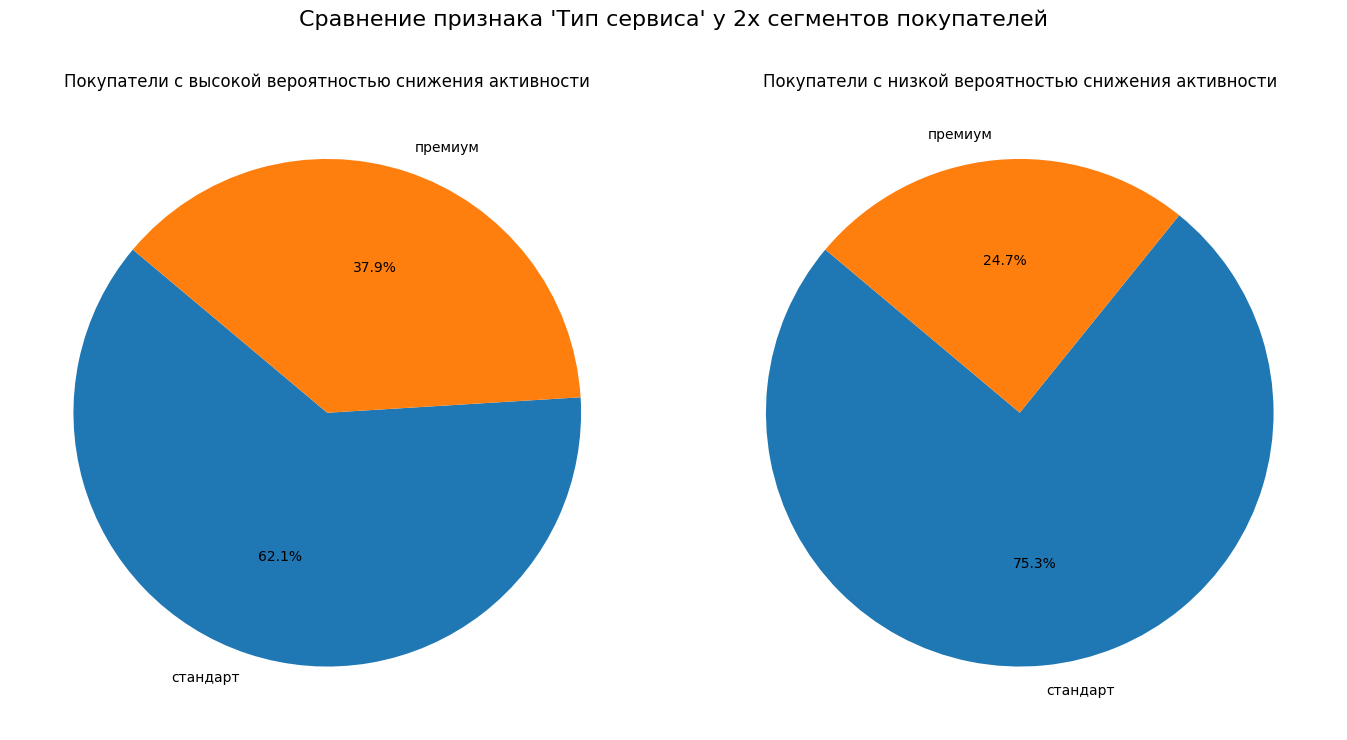

In [80]:
# Подсчёт значений для каждого типа сервиса в двух сегментах
high_decline_service_counts = df_high_decline_high_profit['тип_сервиса'].value_counts()
low_decline_service_counts = df_low_decline_high_profit['тип_сервиса'].value_counts()
# Подготовка данных для графика
labels_high = high_decline_service_counts.index
sizes_high = high_decline_service_counts.values

labels_low = low_decline_service_counts.index
sizes_low = low_decline_service_counts.values

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для сегмента с высокой вероятностью снижения активности
axes[0].pie(sizes_high, labels=labels_high, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Покупатели с высокой вероятностью снижения активности')

# Круговая диаграмма для сегмента с низкой вероятностью снижения активности
axes[1].pie(sizes_low, labels=labels_low, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Покупатели с низкой вероятностью снижения активности')

plt.suptitle("Сравнение признака 'Тип сервиса' у 2х сегментов покупателей", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Значение "премиум" для типа сервиса чаще встречается у покупателей с высокой вероятностью снижения активности по сравнению с другим сегментом покупателей. Возможны следующие причины: 1) Повышенные ожидания: Покупатели премиум-сегмента обычно имеют более высокие ожидания к качеству сервиса. Если эти ожидания не оправдываются, они могут быстрее потерять интерес и активность. 2)Переоценка стоимости: Премиум-сервисы стоят дороже, и со временем покупатели могут начать пересматривать, стоит ли сервис тех денег, которые они за него платят. Это может привести к снижению активности. При использовании стандартных сервисов пользователи подвергаются меньшему финансовому риску, что может уменьшать вероятность их отказа от использования сервиса.

2) Сравним признак 'Разрешить сообщать' для 2х сегментов

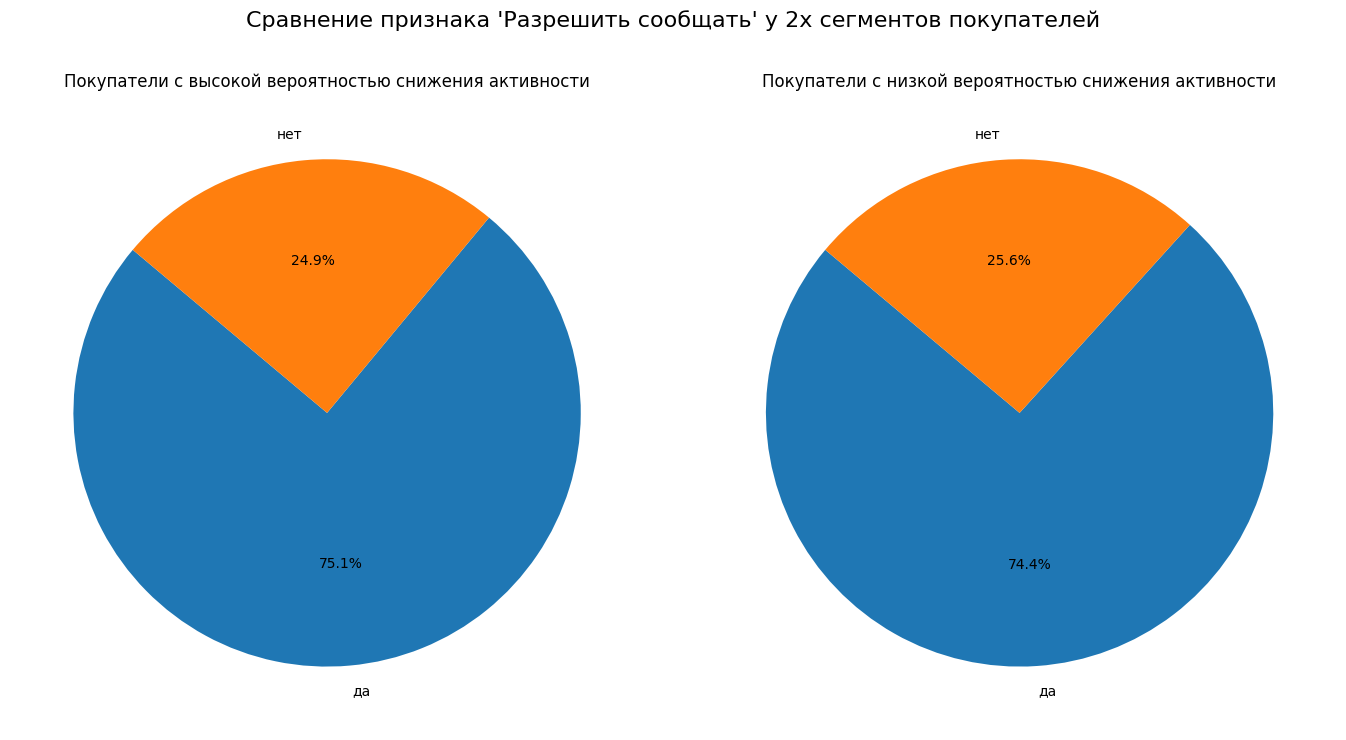

In [81]:
# Подсчёт значений для каждого типа сервиса в двух сегментах
high_decline_service_counts = df_high_decline_high_profit['разрешить_сообщать'].value_counts()
low_decline_service_counts = df_low_decline_high_profit['разрешить_сообщать'].value_counts()
# Подготовка данных для графика
labels_high = high_decline_service_counts.index
sizes_high = high_decline_service_counts.values

labels_low = low_decline_service_counts.index
sizes_low = low_decline_service_counts.values

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для сегмента с высокой вероятностью снижения активности
axes[0].pie(sizes_high, labels=labels_high, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Покупатели с высокой вероятностью снижения активности')

# Круговая диаграмма для сегмента с низкой вероятностью снижения активности
axes[1].pie(sizes_low, labels=labels_low, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Покупатели с низкой вероятностью снижения активности')

plt.suptitle("Сравнение признака 'Разрешить сообщать' у 2х сегментов покупателей", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Значения обоих сегментов пользователей очень похожи

3) Сравним признак 'Маркет актив 6 мес' для 2х сегментов

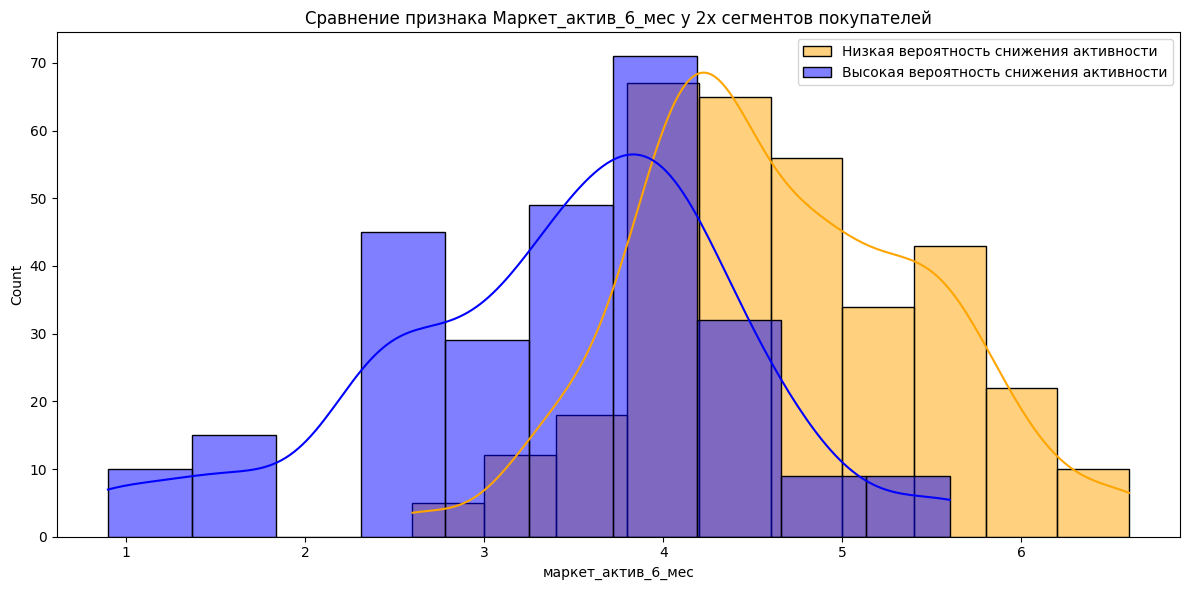

In [82]:
#рассмотрим признак:
feature = 'маркет_актив_6_мес'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=10, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=10, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Маркет_актив_6_мес'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Как видно из данного графика, покупатели, с высокой вероятностью снижения активности за последние 6 месяцев получали намного меньше маркетинговых коммуникаций от компании по сравнению с пользователями, у которых низкая вероятность снижения активности. Это может быть связано с тем, что более частые взаимодействия и напоминания через маркетинговые кампании поддерживают интерес пользователей и удерживают их активными, тогда как недостаток таких коммуникаций может привести к снижению интереса и активности.

4) Сравним признак 'Маркет актив тек мес' для 2х сегментов

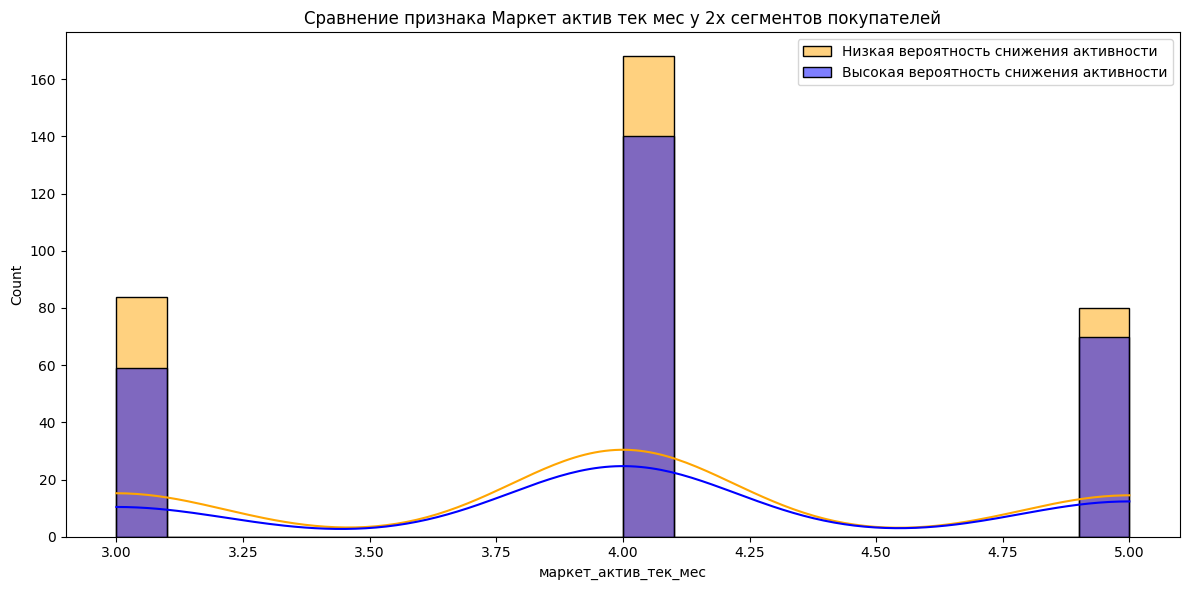

In [83]:
#рассмотрим признак:
feature = 'маркет_актив_тек_мес'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=20, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=20, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Маркет актив тек мес'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Как мы можем заметить, в текущем месяце значения количества маркетинговых коммуникаций у пользователей с высокой вероятностью снижения активности примерно похожи на значения другой группы пользователей.

5) Сравним признак 'Длительность' для 2х сегментов

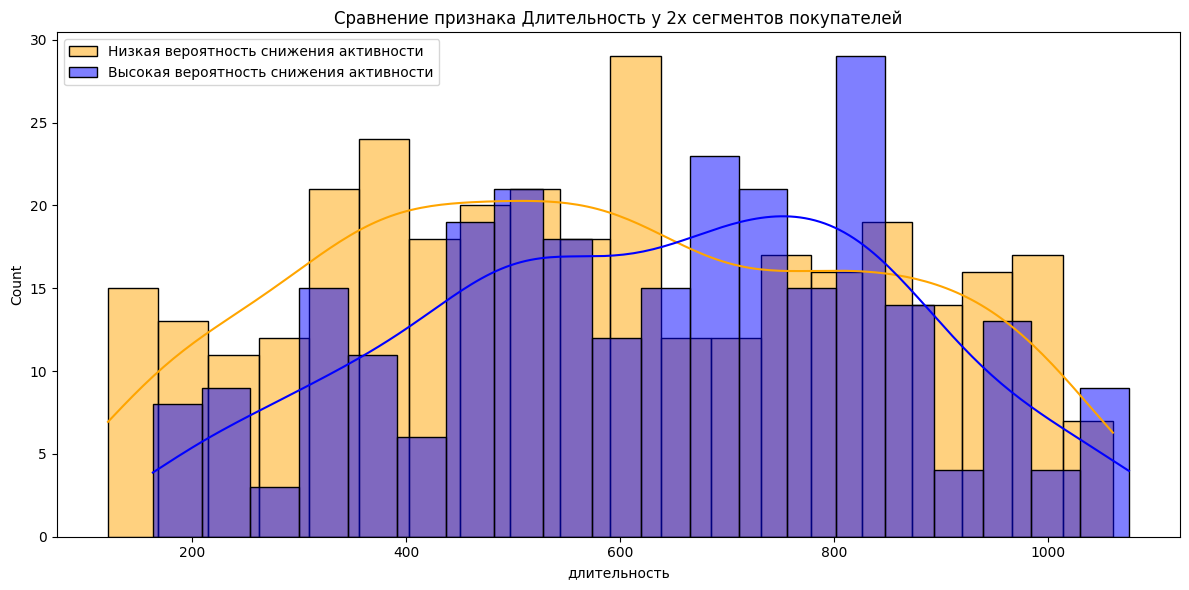

In [84]:
#рассмотрим признак:
feature = 'длительность'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=20, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=20, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Длительность'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Что мы можем заметить, так это то, что много покупателей с высокой вероятностью снижения активности зарегистрировались на сайте немножечко раньше, чем покупатели с низкой вероятностью снижения активности. Это может указывать на то, что более давние пользователи могли изменить свои предпочтения или потерять интерес к продуктам или услугам компании со временем.

6) Сравним признак 'Акционные покупки' для 2х сегментов

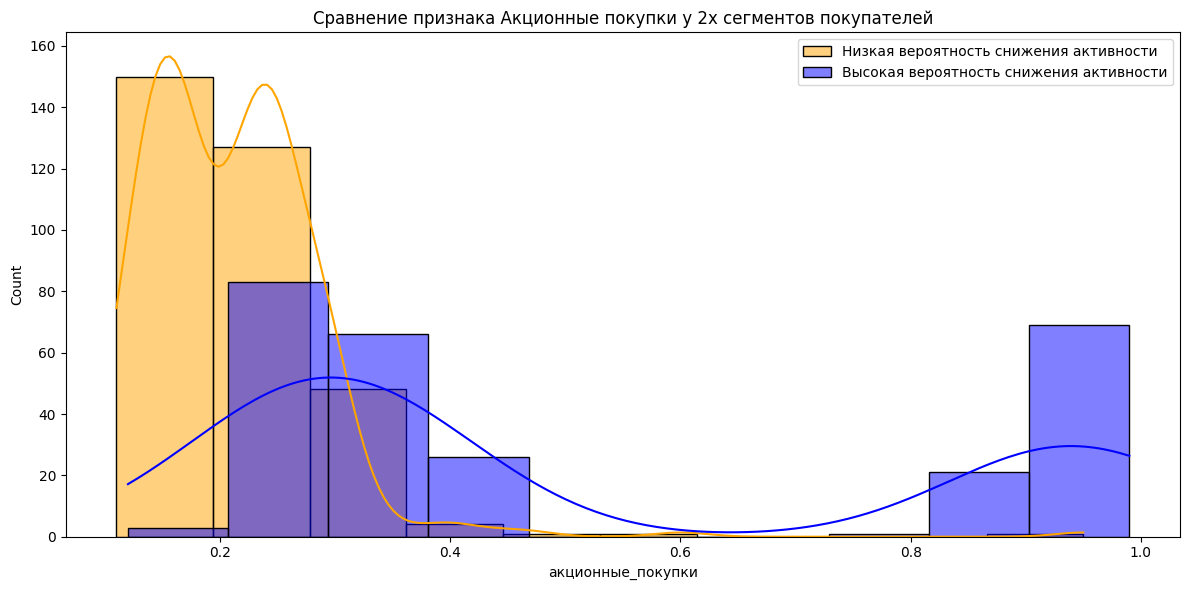

In [85]:
#рассмотрим признак:
feature = 'акционные_покупки'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=10, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=10, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Акционные покупки'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Мы наблюдаем, что покупатели с высокой вероятностью снижения активности часто совершают покупки по акциям. Кроме того, на графике видно, что значительная часть этих покупателей осуществляет почти все свои покупки исключительно по акциям. Это может происходить из-за того, что такие покупатели склонны искать выгодные предложения и менее лояльны к магазину. Они могут переключаться на другие интернет-магазины, если не находят интересных акционных предложений. В результате, отсутствие акций может привести к снижению их активности.

7) Сравним признак 'Популярная категория' для 2х сегментов

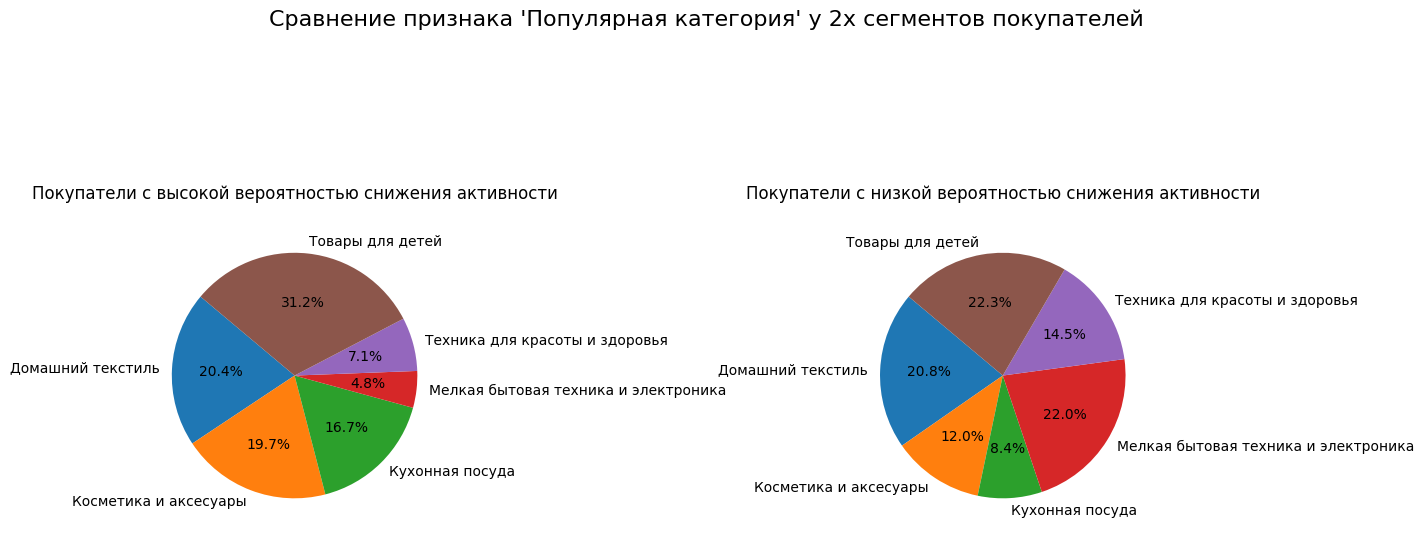

In [86]:
# Подсчёт значений для каждого типа сервиса в двух сегментах
high_decline_service_counts = df_high_decline_high_profit['популярная_категория'].value_counts()
low_decline_service_counts = df_low_decline_high_profit['популярная_категория'].value_counts()

# Создание единого списка категорий
all_categories = sorted(set(high_decline_service_counts.index).union(set(low_decline_service_counts.index)))

# Подготовка данных для графика
sizes_high = [high_decline_service_counts.get(category, 0) for category in all_categories]
sizes_low = [low_decline_service_counts.get(category, 0) for category in all_categories]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для сегмента с высокой вероятностью снижения активности
axes[0].pie(sizes_high, labels=all_categories, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Покупатели с высокой вероятностью снижения активности', y=1.05)

# Круговая диаграмма для сегмента с низкой вероятностью снижения активности
axes[1].pie(sizes_low, labels=all_categories, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Покупатели с низкой вероятностью снижения активности', y=1.05)

plt.suptitle("Сравнение признака 'Популярная категория' у 2х сегментов покупателей", fontsize=16)
plt.tight_layout()
plt.show()

Анализ данных показывает, что определённые категории товаров, такие как товары для детей, косметика и аксесуары, кухонная посуда привлекают больше внимания у пользователей с высокой вероятностью снижения покупательской активности, это может быть сигналом для интернет-магазина уделить им дополнительное внимание. Это также может включать улучшение предложений, акций, или улучшение пользовательского опыта в этих категориях, чтобы стимулировать и удерживать интерес к продуктам среди данной аудитории.

8) Сравним признак 'Средний просмотр категорий за визит' для 2х сегментов

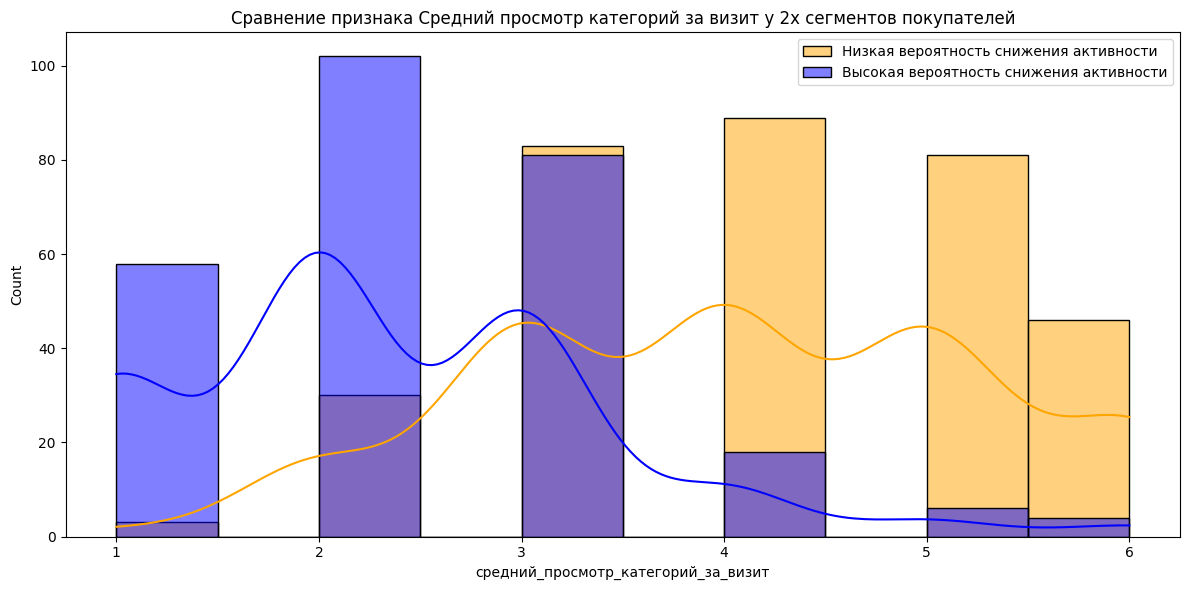

In [87]:
#рассмотрим признак:
feature = 'средний_просмотр_категорий_за_визит'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=10, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=10, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Средний просмотр категорий за визит'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Покупатели с низкой вероятностью снижения активности в среднем, просматривают больше категорий за визит в течение последнего месяца, чем другая группа покупателей. Это может быть связано с тем, что покупатели с низкой вероятностью снижения активности более заинтересованы в разнообразии товаров или услуг, которые предлагает магазин или платформа. Они чаще просматривают различные категории товаров за визит, что может указывать на их более широкие интересы или более активное использование платформы для поиска информации о продуктах.

9) Сравним признак 'Неоплаченные продукты штук квартал' для 2х сегментов

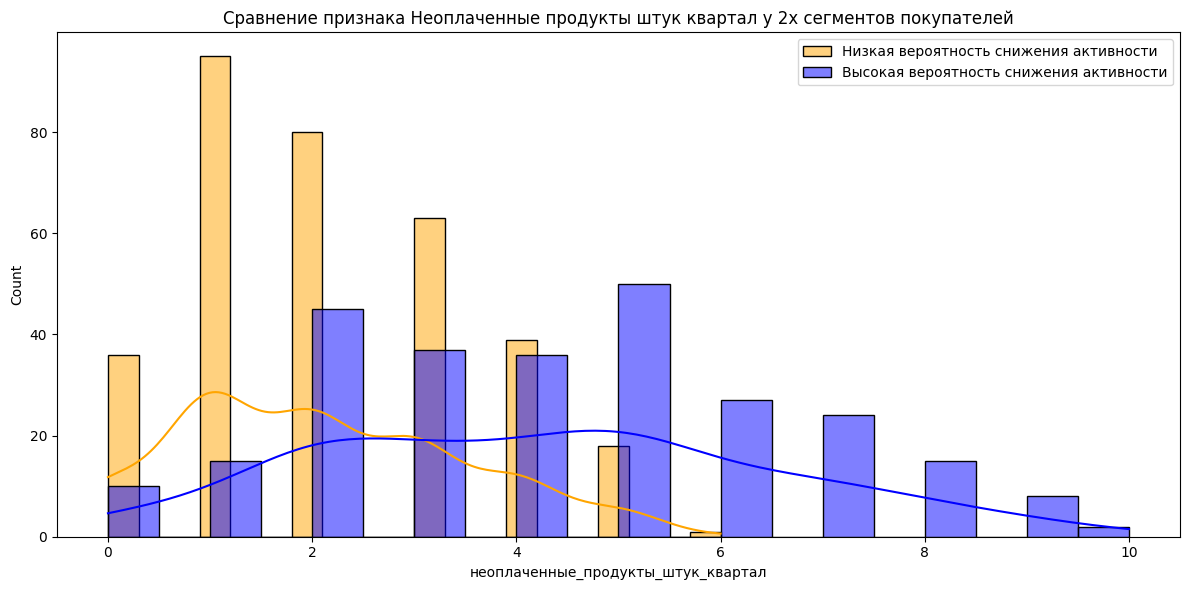

In [88]:
#рассмотрим признак:
feature = 'неоплаченные_продукты_штук_квартал'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=20, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=20, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Неоплаченные продукты штук квартал'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Пользователи с низкой вероятностью снижения покупательской активности имеют намного меньше неоплаченных товаров в своей корзине, нежели пользователи, у который высокая вероятность снижения. Это может быть обусловлено тем, что пользователи с низкой вероятностью снижения покупательской активности, скорее всего, совершают покупки сразу после добавления товаров в корзину или более склонны завершать покупки. В то время как у пользователей с высокой вероятностью снижения активности может быть больше неоплаченных товаров в корзине из-за их менее стабильного поведения или склонности к отказам от покупок в процессе оформления заказа. Пользователи с высокой вероятностью снижения активности могут быть более чувствительны к цене или ищут лучшие предложения, что может приводить к большему количеству неоплаченных товаров в корзине, если они откладывают покупку в ожидании скидок или акций.

10) Сравним признак 'Ошибка сервиса' для 2х сегментов

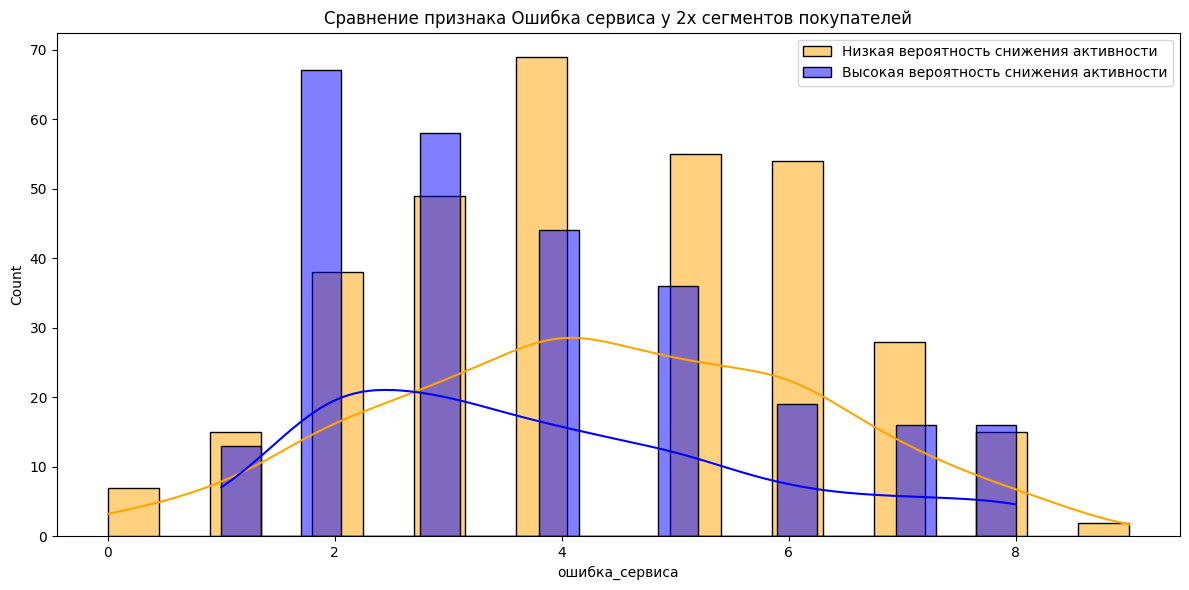

In [90]:
#рассмотрим признак:
feature = 'ошибка_сервиса'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=20, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=20, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Ошибка сервиса'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Покупатели с низкой вероятностью снижения активности столкнулись с большим числом сбоев на сайте по сравнению с покупателями из другой группы. Пользователи с низкой вероятностью снижения активности, вероятно, проводят больше времени на сайте и используют его чаще, что увеличивает вероятность столкновения с техническими сбоями.

11) Сравним признак 'Страниц за визит' для 2х сегментов

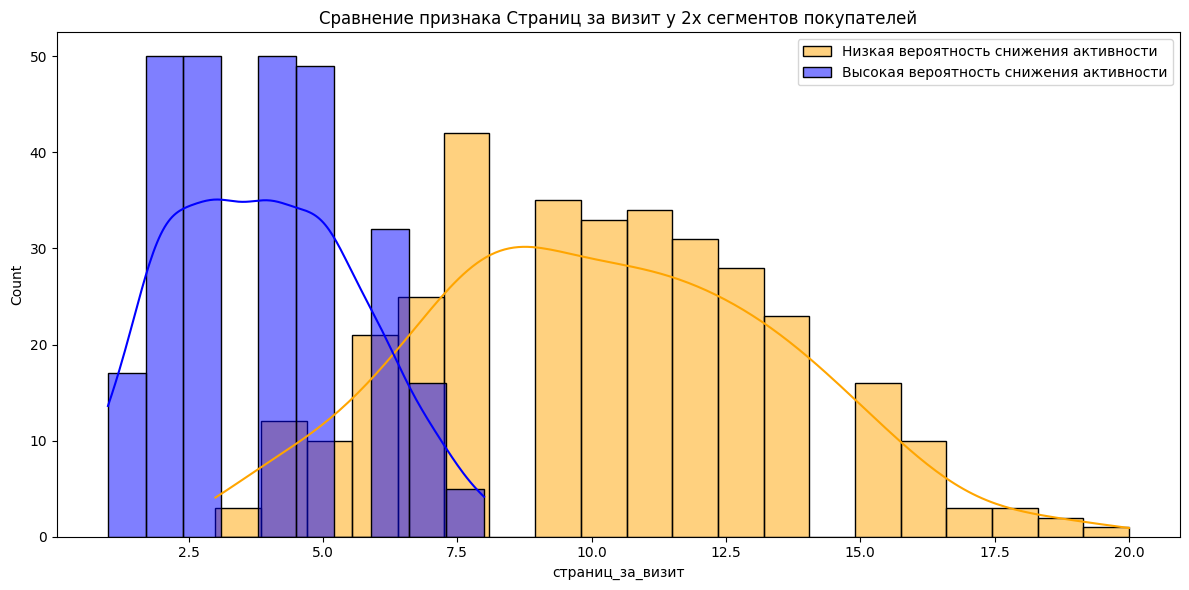

In [91]:
#рассмотрим признак:
feature = 'страниц_за_визит'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=20, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=10, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Страниц за визит'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Среднее количество страниц, просматриваемых за один визит на сайт в течение последних трёх месяцев, значительно выше у пользователей с низкой вероятностью снижения активности. В то время как пользователи с высокой вероятностью снижения активности просматривают гораздо меньше страниц. Поскольку пользователи с низкой вероятностью снижения активности проводят значительно больше времени на сайте, они просматривают больше страниц. Пользователи с низкой вероятностью снижения активности, вероятно, более заинтересованы в контенте и товарах на сайте, что побуждает их исследовать больше страниц за визит.

12) Сравним признак 'Выручка текущий месяц' для 2х сегментов

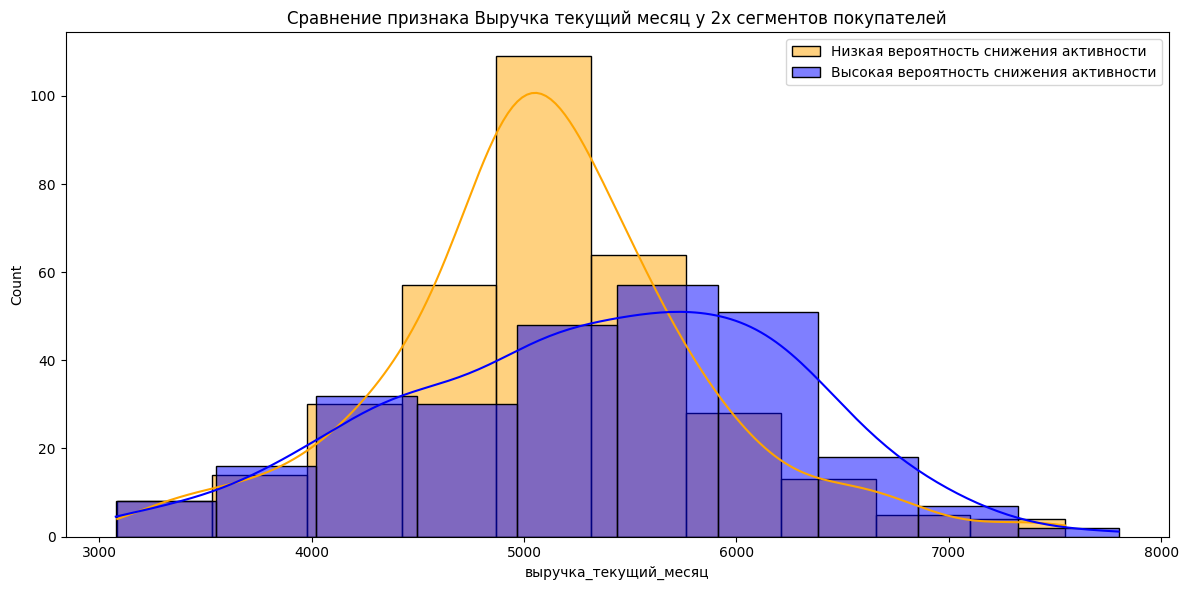

In [92]:
#рассмотрим признак:
feature = 'выручка_текущий_месяц'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=10, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=10, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Выручка текущий месяц'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

У признака "выручка_текущий_месяц" поведение покупателей с низкой вероятностью снижения активности напоминает нормальное распределение. В то время как график другой группы пользователей смещен вправо, что означает, что в среднем они потратили больше денег в магазине в этом месяце. Это может указывать на то, что покупатели с высокой вероятностью снижения активности, хотя и совершают покупки, тратят больше в текущем месяце. Возможно, они пытаются воспользоваться скидками или специальными предложениями перед тем, как сократить свою активность на сайте, что и приводит к более высокой выручке в текущем месяце для этого сегмента. Так что можно сказать, что те, кто склонен к снижению покупательской активности, в текущем месяце сделали больше покупок. Возможно, эти покупатели совершают последние крупные приобретения перед тем, как потерять интерес к дальнейшим покупкам.

13) Сравним признак 'Минут предыдущий месяц' для 2х сегментов

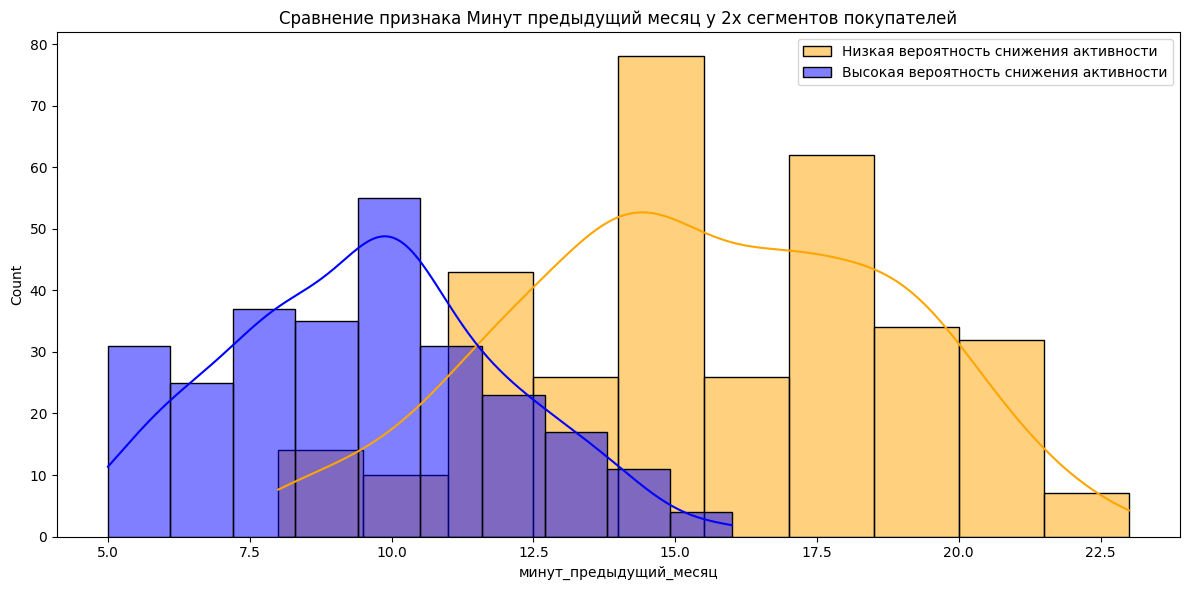

In [93]:
#рассмотрим признак:
feature = 'минут_предыдущий_месяц'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=10, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=10, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Минут предыдущий месяц'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Пользователи с высокой вероятностью снижения активности в прошлом месяце провели на сайте меньше времени по сравнению с другой группой пользователей. Это может указывать на уменьшение их интереса к сайту и, возможно, на начало снижения их покупательской активности.

14) Сравним признак 'Минут текущий месяц' для 2х сегментов

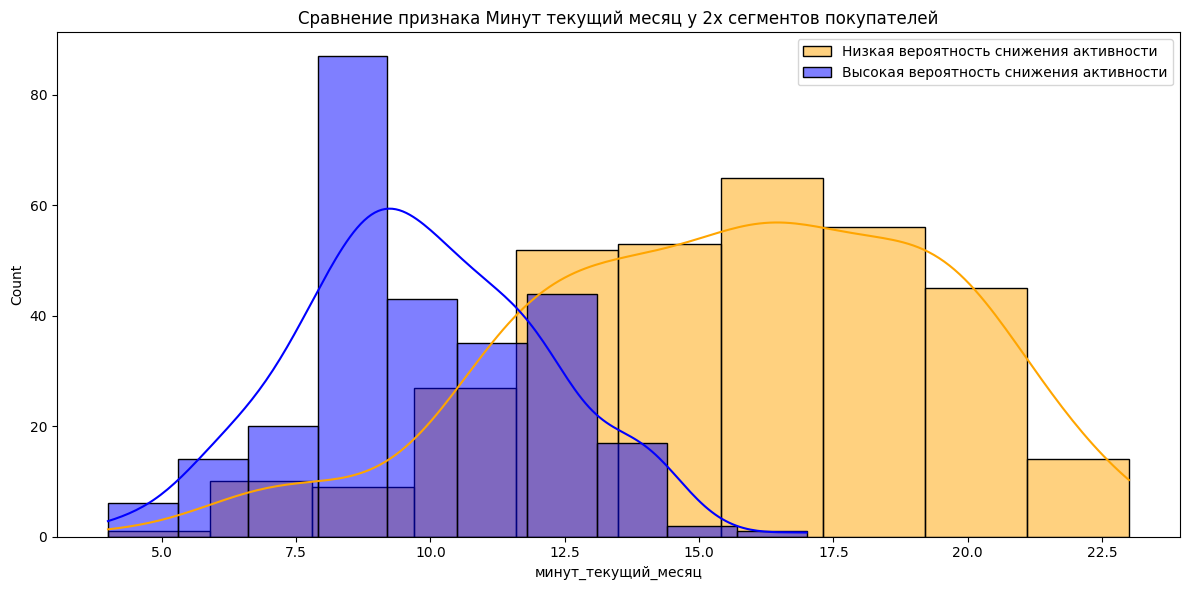

In [94]:
#рассмотрим признак:
feature = 'минут_текущий_месяц'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=10, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=10, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Минут текущий месяц'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

В текущем месяце у двух группы пользователей примерно такая же ситкация как и в предыдущем месяце.

15) Сравним признак 'Прибыль' для 2х сегментов

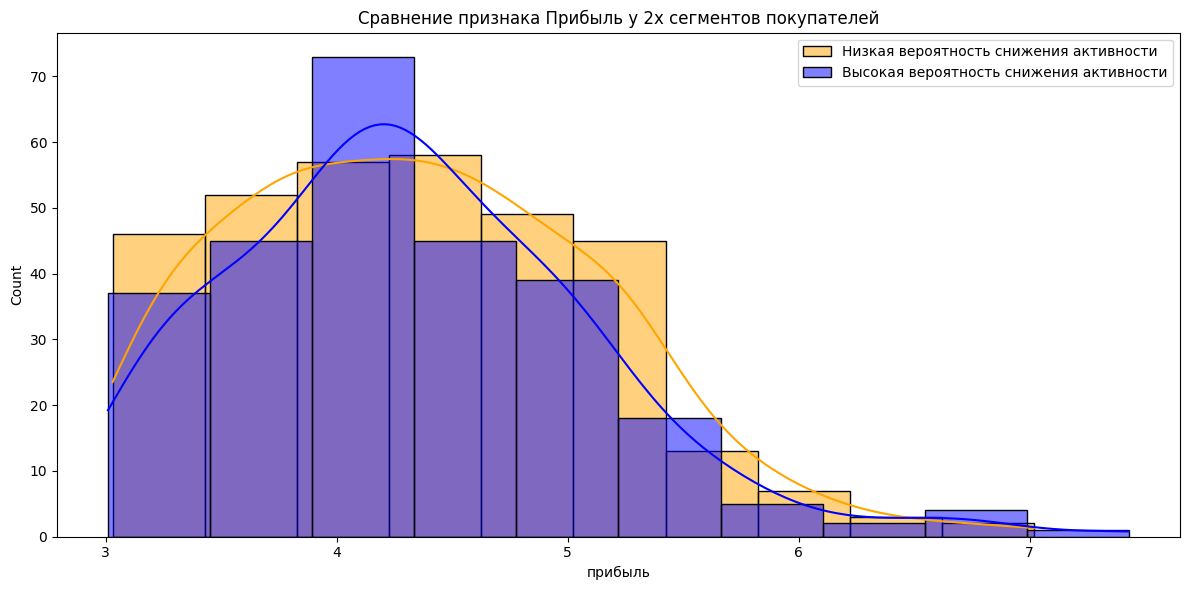

In [95]:
#рассмотрим признак:
feature = 'прибыль'

plt.figure(figsize=(12, 6))

# Построение гистограммы для сегмента с низкой вероятностью снижения
sns.histplot(df_low_decline_high_profit[feature], bins=10, color='orange', label='Низкая вероятность снижения активности', kde=True)

# Построение гистограммы для сегмента с высокой вероятностью снижения
sns.histplot(df_high_decline_high_profit[feature], bins=10, color='blue', label='Высокая вероятность снижения активности', kde=True)

# Добавление заголовка и легенды
plt.title('Сравнение признака ''Прибыль'' у 2х сегментов покупателей')
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()

Данные о среднемесячной прибыли магазина от двух сегментов покупателей за последние три месяца примерно одинаковы.

В итоге после 8 шага можно написать небольшое обобщение по сегментации покупателей:

Для сегментации покупателей мы использовали результаты моделирования и данные о прибыльности покупателей. Установили порог, который используется для классификации предсказанных вероятностей модели. В нашем случае, если предсказанная вероятность того, что покупатель снизит свою активность, больше порога, то модель считает, что активность покупателя снизится. Использовали нашу лучшую модель, чтобы предсказать вероятности класса "Снижение" для данных, которые были предварительно обработаны. Добавили значение прибыли к таблице. И таким образом, df_decline содержит только те строки, для которых модель предсказала снижение активности. Также выделили сегмент высокоприбыльных покупателей, у которых значение прибыли больше 3.

После мы выделили 2 сегмента:
- Сегмент высокоприбыльных покупателей с высокой вероятностью снижения активности: Этот сегмент включает покупателей, для которых предсказана высокая вероятность снижения активности и которые приносят значительную прибыль.
- Сегмент высокоприбыльных покупателей с низкой вероятностью снижения активности: Этот сегмент включает покупателей, для которых предсказана низкая вероятность снижения активности и которые также приносят значительную прибыль.

Эти сегменты были выбраны для сравнения, чтобы понять различия в поведении высокоприбыльных покупателей, которые могут потерять интерес к покупкам, и тех, кто вероятно останется активным. Понимание этих различий позволяет разработать более целевые стратегии для удержания высокоприбыльных клиентов, которые могут снизить свою активность, и оптимизировать маркетинговые усилия для максимизации дохода от всех клиентов.

Таким образом, сравнение этих двух сегментов позволяет выявить ключевые различия в поведении покупателей и принять обоснованные бизнес-решения для улучшения удержания клиентов и увеличения прибыли.

Далее мы построили графики для каждого признака, чтобы сравнить эти сегменты.

1) Тип сервиса: Значение "премиум" для типа сервиса чаще встречается у покупателей с высокой вероятностью снижения активности по сравнению с другим сегментом. Возможная причина в том, что премиум-сервисы стоят дороже, и со временем покупатели могут пересматривать, стоит ли сервис своих денег, что приводит к снижению активности. Пользователи стандартных сервисов подвергаются меньшему финансовому риску, что уменьшает вероятность отказа от использования сервиса.
2) Разрешить сообщать: Значения обоих сегментов пользователей очень похожи
3) Маркет актив 6 мес: Покупатели с высокой вероятностью снижения активности за последние 6 месяцев получали значительно меньше маркетинговых коммуникаций от компании по сравнению с пользователями с низкой вероятностью снижения активности. Это может объясняться тем, что более частые взаимодействия и напоминания через маркетинговые кампании поддерживают интерес пользователей и удерживают их активными, тогда как недостаток таких коммуникаций может привести к снижению интереса и активности.
4) Маркет актив тек мес: В текущем месяце значения количества маркетинговых коммуникаций у пользователей с высокой вероятностью снижения активности примерно похожи на значения другой группы пользователей.
5) Длительность: Много покупателей с высокой вероятностью снижения активности зарегистрировались на сайте значительно раньше, чем покупатели с низкой вероятностью снижения активности. Со временем эти пользователи могли изменить свои предпочтения или потерять интерес к продуктам компании.
6) Акционные покупки: Покупатели с высокой вероятностью снижения активности часто совершают покупки по акциям. На графике также видно, что значительная часть этих покупателей делает почти все свои покупки исключительно по акциям. Это связано с их стремлением к выгодным предложениям и низкой лояльностью к магазину. Они могут переходить к другим интернет-магазинам, если не находят интересных акционных предложений, что в итоге приводит к снижению их активности.
7) Популярная категория: Пользователи с высокой вероятностью снижения активности чаще просматривают такие категории, как товары для детей, косметика и аксесуары, кухонная посуда. Интернет-магазину стоит уделить дополнительное внимание этим товарам.
8) Средний просмотр категорий за визит: Покупатели с низкой вероятностью снижения активности в среднем просматривают больше категорий товаров за визит в течение последнего месяца, чем другая группа покупателей. Это может объясняться тем, что они проявляют больший интерес к разнообразию товаров или услуг, предлагаемых магазином или платформой. Они чаще исследуют различные категории товаров во время каждого посещения, что может указывать на их более широкие интересы или активное использование платформы для поиска информации о продуктах.
9) Неоплаченные продукты штук квартал: Пользователи с низкой вероятностью снижения покупательской активности имеют меньше неоплаченных товаров в корзине по сравнению с пользователями, у которых вероятность снижения высока. Это может объясняться тем, что такие пользователи скорее совершают покупки сразу после добавления товаров в корзину или более решительны в завершении покупок. В то время как у пользователей с высокой вероятностью снижения активности часто остаются неоплаченные товары в корзине из-за их менее стабильного поведения или склонности отказываться от покупок в процессе оформления заказа. Эти пользователи могут быть более ценово чувствительными или ожидать лучшие предложения, что также может приводить к большему количеству неоплаченных товаров в корзине.
10) Ошибка сервиса: Покупатели с низкой вероятностью снижения активности сталкиваются с большим числом сбоев на сайте по сравнению с другой группой. Это связано с тем, что они, вероятно, чаще используют сайт и проводят на нем больше времени, что повышает вероятность возникновения технических сбоев.
11) Страниц за визит: Пользователи с низкой вероятностью снижения активности просматривают значительно больше страниц за один визит на сайт в течение последних трех месяцев, чем пользователи с высокой вероятностью снижения активности. Это связано с их большим временем, проводимым на сайте, что стимулирует исследование большего числа страниц.
12) Выручка текущий месяц: Поведение покупателей с низкой вероятностью снижения активности напоминает нормальное распределение, в то время как график другой группы пользователей смещен вправо. Это указывает на то, что в среднем пользователи с высокой вероятностью снижения активности тратят больше денег в магазине в текущем месяце. Возможно, такие пользователи стараются воспользоваться скидками или специальными предложениями перед снижением активности, что приводит к выше выручке для этого сегмента.
13) Минут предыдущий месяц: Пользователи с высокой вероятностью снижения активности в прошлом месяце провели на сайте меньше времени по сравнению с другой группой пользователей. Это может указывать на уменьшение их интереса к сайту и, возможно, на начало снижения их покупательской активности.
14) Минут текущий месяц: В текущем месяце у двух группы пользователей примерно такая же ситкация как и в предыдущем месяце.
15) Прибыль: Среднемесячная прибыль магазина от двух сегментов покупателей за последние три месяца примерно одинаковая.

**Рекомендации по работе с сегментами для увеличения покупательской активности**

На основании проведенного анализа можно выделить несколько стратегий для повышения покупательской активности, особенно среди сегмента с высокой вероятностью снижения активности.

- Оптимизация премиум-сервисов: Учитывая, что пользователи с высокой вероятностью снижения активности чаще выбирают премиум-сервисы, необходимо повышать качество и стимулировать удовлетворение от использования этих услуг. Регулярно опрашивайте клиентов и анализируйте их отзывы, чтобы соответствовать их ожиданиям.
- Персонализированные маркетинговые кампании: Поскольку покупатели с высокой вероятностью снижения активности получают меньше маркетинговых коммуникаций, нужно увеличить частоту и персонализацию маркетинговых кампаний для этого сегмента. Это поможет поддерживать их интерес и активность. Разработать персонализированные предложения, которые будут более релевантны интересам и потребностям каждого покупателя. Сегментировать рассылки, отправляя более целевые сообщения покупателям с высокой вероятностью снижения активности. Например, предложите специальные акции или скидки на категории товаров, которые они чаще всего просматривают.
- Улучшение пользовательского опыта: Сделать акцент на улучшение пользовательского интерфейса и удобства навигации, особенно для категорий, таких как товары для детей, косметика и аксесуары, кухонная посуда, которые привлекают больше внимания покупателей с высокой вероятностью снижения активности. Добавить рекомендации и отзывы для продуктов из этих категорий, чтобы увеличить их привлекательность.
- Стимулирование акционных покупок: Учитывая, что сегмент покупателей с высокой вероятностью снижения активности часто реагирует на акционные предложения, нкжно предлагать им персонализированные скидки и акции. Это может увеличить частоту покупок и удержание клиентов.
Напоминания о товарах в корзине: Отправлять напоминания о товарах, оставленных в корзине, особенно покупателям с высокой вероятностью снижения активности, которые имеют больше неоплаченных товаров. Это может стимулировать их завершить покупки. Предлагать небольшие скидки или бесплатную доставку для завершения покупки.
- Повышение активности на сайте: Учитывая, что среднее количество страниц, просматриваемых за визит, и время на сайте у покупателей с высокой вероятностью снижения активности намного ниже, то стоит уделить внимание созданию более привлекательного контента и предложений на сайте, особенно для категорий, товары для детей, косметика и аксесуары, кухонная посуда. Например, можно добавить интерактивные элементы, такие как видеообзоры продуктов. Проводить онлайн-мероприятия, вебинары или прямые трансляции с демонстрацией новых продуктов или специальных предложений.
- Программы лояльности для давних клиентов: Ввесит специальные программы лояльности, ориентированные на долгосрочных клиентов. Предлагать бонусные баллы, скидки или эксклюзивные предложения, доступные только для пользователей, зарегистрированных на сайте более определенного периода времени.

Эти рекомендации помогут нам более эффективно работать с различными сегментами покупателей и увеличить их активность, что в конечном итоге приведет к росту продаж.

## Шаг 9. Общий вывод

В данной работе был проведен комплексный анализ данных интернет-магазина «В один клик» с целью разработки персонализированных предложений для постоянных клиентов. Основное внимание было уделено снижению покупательской активности и выявлению факторов, влияющих на поведение клиентов.

Первым делом были собраны и предобработаны данные. Мы заметили, что исходные датафреймы не содержат пропусков, и все столбцы имеют правильный тип данных. Мы провели предобработку данных, чтобы обеспечить точность и полноту нашего исследования. Сначала мы привели имена столбцов к нижнему регистру и устранили пробелы между словами. Затем мы тщательно проверили датасеты на наличие пропусков — их не обнаружили. Далее следовала проверка на явные и неявные дубликаты. Явных дубликатов не было, а неявные мы заменили на корректные значения. Мы также убедились, что типы данных в исходных датафреймах были правильными и не требовали изменений.

В следуюшем этапе исследования данных клиентов интернет-магазина мы сделали следующее:
Были отобраны клиенты с покупательской активностью не менее трех месяцев. Исключены клиенты с нулевой выручкой, что указывает на их низкую покупательскую активность.
Были определены признаки:
- Количественные признаки: В market_file: 'маркет_актив6мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит' В market_money: 'выручка' В market_time: 'минут' В money: 'прибыль'
- Категориальные признаки: В market_file: 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория'. В market_money и market_time: 'период'.

Был произведен анализ количественных признаков и построение графиков — гистограммы частотности распределения и ящик с усами для каждого признака:

1) 'Маркет актив 6 мес': за последние 6 месяцев (маркет_актив6мес) показали маркетинговых коммуникаций находятся на промежутке от 3.7 до 4.9. Гистограмма похожа на график нормального распределения со смещением вправо. По диаграмме размаха мы также видим несколько выбрасов и убираем их.
2) У показалей 'Маркет актив тек мес' всего 3 уникальных значения (3, 4, 5). Чаще всего у польщователей и компании 4 коммуникации.
3) 'Длительность': большинство клиентов зарегистрированы на сайте от 410 до 806 дней. Гистограмма похожа на график нормального распределения. По диаграмме размаха выбрасов нет.
4) 'Акционные покупки': большая часть данных находится в диапазоне от 0.17 до 0.3, и в данных присутсивуют выбросы, которые мы не удаляем.
5) 'Средний просмотр категорий за визит': в среднем, клиенты просматривают 3 категории за визит.
6) 'Неоплаченные продукты штук квартал': большинство клиентов оставляют в корзине от 1 до 4 неоплаченных товаров.
7) 'Ошибка сервиса': среднее значение ошибок равно 4. В данных выбрасов не обнаружено.
8) 'Страниц за визит': данные варьируется от 1 до 20 страниц, и в среднем 8 страниц, просматриваемых за визит, за 3 месяца на пользователя. Выбрасов не имеется.
9) 'Выручка': большинство значений выручки находится в диапазоне от 4500 до 5300. Больше всего сумма выручки в среднем равна 5000. Гистограмма похожа на график нормального распределения. По диаграмме размаха мы также видим немного выбрасов, которые оставляем без обработки.
10) 'Минут': большинство клиентов проводят на сайте от 10 до 16 минут. Выбрасов в данных нет.
11) 'Прибыль': большинство значений прибыли находится в диапазоне от 0.8 до 7.4. Гистограмма похожа на график нормального распределения со смещением вправо. Выбрасы оставляем без обработки.

Также мы проанализировали категориальные признаки и также построили графики:

1) 'Покупательская активность': у большинства клиентов (около 800) активность осталась на прежнем уровне, у 495 снизилась.
2) 'Тип сервиса': у 922 клиентов сервис 'Стандарт', у остальных 'Премиум'.
3) 'Разрешить сообщать': на рассылку согласных почти в 3 раза больше клиентов, чем не согласных.
4) 'Популярная категория': наиболее популярна категория 'Товары для детей', менее популярна 'Кухонная посуда'.
5) 'Период, во время которого зафиксирована выручка': выручка зафиксирована за последние 3 месяца.
6) 'Период, во время которого зафиксировано общее время': время зафиксировано за последние за 2 месяца.

Проведенный анализ выявил важные особенности покупательской активности и взаимодействия клиентов с интернет-магазином. В целом, полученные результаты могут использоваться для дальнейшего улучшения взаимодействия с клиентами и эффективного управления бизнес-процессами интернет-магазина.

Далее, наш следующий шаг включал в себя объединение и преобразование данных из трех исходных таблиц: market_file.csv, market_money.csv и market_time.csv. Каждая таблица предоставляла различные аспекты информации о рынке, включая основные данные, выручку и время на сайте.

Особенностью данных о выручке и времени являлось их хранение в одном столбце для всех трех периодов: предпредыдущий месяц, предыдущий месяц и текущий месяц. Для удобства анализа мы структурировали эти данные, преобразовав их таким образом, чтобы каждый период имел свой отдельный столбец в итоговой таблице. Затем мы объединили все три таблицы по уникальному идентификатору покупателя. В результате была получена таблица, где каждая строка соответствует определенному id покупателя, а столбцы содержат данные о выручке и времени для каждого из трех периодов.

Для анализа взаимосвязей мы построили тепловую карту корреляций, разделяя пользователей на две категории: снижение активности и прежняя активность. Также провели проверку на мультиколлинеарность между независимыми признаками с целью выявления потенциальных проблемных переменных, которые могут повлиять на стабильность и интерпретируемость регрессионной модели.

Выявлены и удалены признаки с высокой корреляцией (близкой к 1), такие как "выручка_предыдущий_месяц" и "выручка_предпредыдущий_месяц". Анализ корреляционной матрицы показал, что большинство коэффициентов находятся в приемлемых пределах, свидетельствуя об отсутствии значительной линейной зависимости между признаками. Значения коэффициентов корреляции лишь в редких случаях приближаются к 0.7.

Дополнительно были вычислены коэффициенты инфляции дисперсии (VIF), подтверждающие низкую степень мультиколлинеарности между признаками, что важно для устойчивости и интерпретируемости модели.

Можно сказать, что наш набор данных демонстрирует низкий уровень мультиколлинеарности. Это позитивно влияет на возможность построения и использования надежной регрессионной модели с выбранными признаками, обеспечивая их устойчивость и интерпретируемость.

Далее, нам было необходимо построить и выбрать лучшую модель, которая предскажет вероятность снижения покупательской активности клиента.

Данные были подготовлены с использованием пайплайнов, включая применение ColumnTransformer для разделения признаков на количественные и категориальные. Категориальные признаки 'популярная_категория' и 'разрешить_сообщать' были закодированы с помощью OneHotEncoder, а 'тип_сервиса' — с помощью OrdinalEncoder. Количественные признаки были масштабированы. Далее данные были разделены на тренировочную и тестовую выборки.

Было обучено четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой модели был выполнен подбор гиперпараметров с использованием пайплайнов. Оценка качества моделей проводилась по метрике ROC-AUC. И также был построен график ROC-кривой для каждой модели.

Значения на тренировочной выборке получились следующие:   
KNeighborsClassifier: 0.90895  
DecisionTreeClassifier: 0.87779  
LogisticRegression: 0.90038  
SVC: 0.89278  
  
Все модели показали высокие значения ROC-AUC, что свидетельствует о их хорошей способности различать классы. Модели KNeighborsClassifier() и LogisticRegression() демонстрируют самые высокие значения: 0.90895 и 0.90038 соответственно. Из рассмотренных моделей, KNeighborsClassifier() можно рассматривать как лучшую, хотя разница между ней и LogisticRegression() минимальна.

Таким образом, **модель KNeighborsClassifier()** выделяется среди остальных по метрике ROC-AUC и может быть рекомендована для использования в дальнейших приложениях в качестве наилучшей модели.

В добавок, мы провели анализ важности признаков для нашей лучшей модели с использованием метода SHAP и построили соответствующий график. На основании этого анализа мы выявили следующие закономерности:

Активность пользователя снижается, если: 
1) будет маленькое количество просмотренных страниц за визит;
2) пользователь будет проводить недолгое время на сайте;
3) среднее число просмотренных категорий за визит будет очень маленькое; 
4) будет мало маркетинговых коммуникаций с клиентом
   
Признаки, которые оказались малозначимыми для модели: 
1) Страниц за визит,
2) Минут предыдущий месяц,
3) Минут текущий месяц
   
Наибольшее влияние на целевой признак оказывают: 
1) Разрешить сообщать,
2) Тип сервиса,
3) Маркет актив тек месяц,
4) Популярная категория (Кухонная посуда, Косметика и аксессуары).
5) 
Эти наблюдения предоставляют ценную информацию для разработки стратегий и принятия бизнес-решений:

Для увеличения активности клиентов можно сосредоточиться на улучшении пользовательского интерфейса и контента сайта, что способствует увеличению просматриваемых страниц за визит.
Улучшение клиентского сервиса и предложений для клиентов с высокой активностью может способствовать их удержанию и стимулированию дальнейшей активности.
Анализ предпочтений клиентов относительно коммуникаций помогает оптимизировать стратегии взаимодействия, минимизируя перегрузку информацией и улучшая персонализацию коммуникаций.

Произведенный анализ важности признаков с использованием метода SHAP предоставил нам полезную информацию о факторах, влияющих на активность клиентов. Эти знания могут быть эффективно использованы для оптимизации маркетинговых стратегий, улучшения клиентского опыта и повышения лояльности клиентов.

И наконец, мы выполнили сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей.

Был установлен порог, который используется для классификации предсказанных вероятностей модели. В нашем случае, если предсказанная вероятность того, что покупатель снизит свою активность, больше порога, то модель считает, что активность покупателя снизится. Использовали нашу лучшую модель, чтобы предсказать вероятности класса "Снижение" для данных, которые были предварительно обработаны. Добавили значение прибыли к таблице. Также выделили сегмент высокоприбыльных покупателей, у которых значение прибыли больше 3.

В итоге, после всех преобразований получили 2 сегмента покупателей:

1) Сегмент высокоприбыльных покупателей с высокой вероятностью снижения активности: Этот сегмент включает покупателей, для которых предсказана высокая вероятность снижения активности и которые приносят значительную прибыль.
2) Сегмент высокоприбыльных покупателей с низкой вероятностью снижения активности: Этот сегмент включает покупателей, для которых предсказана низкая вероятность снижения активности и которые также приносят значительную прибыль.

Эти сегменты были выбраны для сравнения, чтобы понять различия в поведении высокоприбыльных покупателей, которые могут потерять интерес к покупкам, и тех, кто вероятно останется активным. Понимание этих различий позволяет разработать более целевые стратегии для удержания высокоприбыльных клиентов, которые могут снизить свою активность, и оптимизировать маркетинговые усилия для максимизации дохода от всех клиентов. Сравнение этих двух сегментов позволяет выявить ключевые различия в поведении покупателей и принять обоснованные бизнес-решения для улучшения удержания клиентов и увеличения прибыли.

После построения графиков и анализа всех признаков для 2х сегментов покупателей, мы можем дать рекомендации или разработать стратегии для увеличения покупательской активности.

Оптимизация премиум-сервисов: Учитывая, что пользователи с высокой вероятностью снижения активности чаще выбирают премиум-сервисы, необходимо повышать качество и стимулировать удовлетворение от использования этих услуг. Регулярно опрашивайте клиентов и анализируйте их отзывы, чтобы соответствовать их ожиданиям.

Персонализированные маркетинговые кампании: Поскольку покупатели с высокой вероятностью снижения активности получают меньше маркетинговых коммуникаций, нужно увеличить частоту и персонализацию маркетинговых кампаний для этого сегмента. Это поможет поддерживать их интерес и активность. Разработать персонализированные предложения, которые будут более релевантны интересам и потребностям каждого покупателя. Сегментировать рассылки, отправляя более целевые сообщения покупателям с высокой вероятностью снижения активности. Например, предложите специальные акции или скидки на категории товаров, которые они чаще всего просматривают.

Улучшение пользовательского опыта: Сделать акцент на улучшение пользовательского интерфейса и удобства навигации, особенно для категорий, таких как товары для детей, косметика и аксесуары, кухонная посуда, которые привлекают больше внимания покупателей с высокой вероятностью снижения активности. Добавить рекомендации и отзывы для продуктов из этих категорий, чтобы увеличить их привлекательность.

Стимулирование акционных покупок: Учитывая, что сегмент покупателей с высокой вероятностью снижения активности часто реагирует на акционные предложения, нкжно предлагать им персонализированные скидки и акции. Это может увеличить частоту покупок и удержание клиентов.

Напоминания о товарах в корзине: Отправлять напоминания о товарах, оставленных в корзине, особенно покупателям с высокой вероятностью снижения активности, которые имеют больше неоплаченных товаров. Это может стимулировать их завершить покупки. Предлагать небольшие скидки или бесплатную доставку для завершения покупки.

Повышение активности на сайте: Учитывая, что среднее количество страниц, просматриваемых за визит, и время на сайте у покупателей с высокой вероятностью снижения активности намного ниже, то стоит уделить внимание созданию более привлекательного контента и предложений на сайте, особенно для категорий, товары для детей, косметика и аксесуары, кухонная посуда. Например, можно добавить интерактивные элементы, такие как видеообзоры продуктов. Проводить онлайн-мероприятия, вебинары или прямые трансляции с демонстрацией новых продуктов или специальных предложений.

Программы лояльности для давних клиентов: Ввесит специальные программы лояльности, ориентированные на долгосрочных клиентов. Предлагать бонусные баллы, скидки или эксклюзивные предложения, доступные только для пользователей, зарегистрированных на сайте более определенного периода времени.

Эти рекомендации помогут интернет-магазину «В один клик» наиболее эффективно работать с различными сегментами покупателей и увеличить их активность, что в конечном итоге приведет к росту продаж, тем самым увеличится покупательскую активность в магазине.